In [1]:
%matplotlib inline

#Enable reloading because restarting the kernel is a pain
%load_ext autoreload
%autoreload 2

import shapely
from shapely.geometry import Polygon, Point

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np

from bot_2d_rep import *
from bot_2d_problem import *

import copy

from jupyter_dash import JupyterDash
from dash import html, dcc, Input, Output
import plotly.graph_objects as go
import pandas as pd

from tqdm.notebook import trange, tqdm

In [2]:
import datetime

timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
bot_name = "Spot"

# Set up & run the simple MOO problem

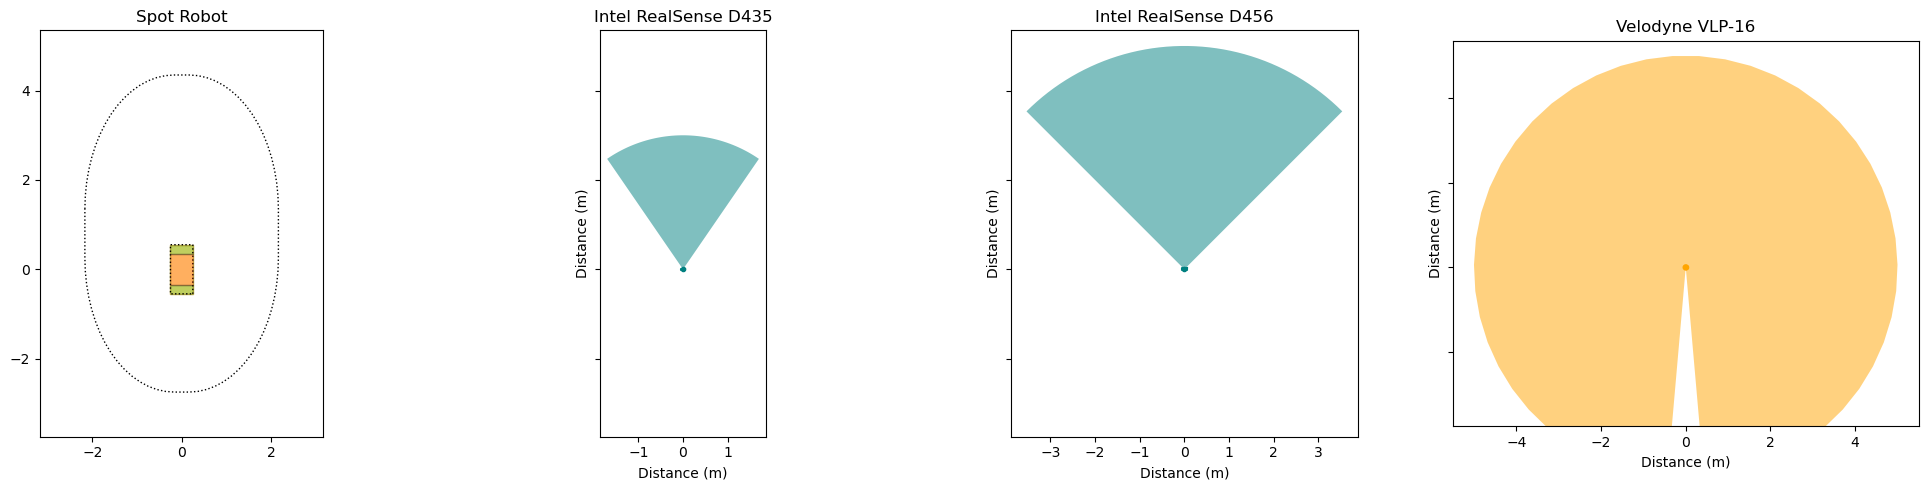

In [3]:
intel_d435_bounds = Polygon([(.045,.0125), (-.045,.0125),(-.045,-.0125),(.045,-.0125)])
intel_d456_bounds = Polygon([(.124/2, .036/2), (-.124/2, .036/2), (-.124/2, -.036/2), (.124/2, -.036/2)])
vel_lidar_bounds = Point(0, 0).buffer(0.0515)
intel_lidar_bounds = Polygon([(.061/2, .026/2), (-.061/2, .026/2), (-.061/2, -.026/2), (.061/2, -.026/2)])

sensor_options = [FOV2D_Simple(hfov=69, distance=(0.3,3.0), cost=314.00, color="teal", bounds_polygon=intel_d435_bounds, name="Intel RealSense D435"),
                  FOV2D_Simple(hfov=90, distance=(0.6,5.0), cost=499.00, color="teal", bounds_polygon=intel_d456_bounds, name="Intel RealSense D456"), #Truncated to 5m for better plotting
                  FOV2D_Simple(hfov=350, distance=5.0, cost=4600.00, color="orange", bounds_polygon=vel_lidar_bounds, name="Velodyne VLP-16"), #Truncated to 5m for better plotting
                  # FOV2D_Simple(hfov=70, distance=(0.25,6.0), cost=589.00, color="orange", bounds_polygon=intel_lidar_bounds, name="Intel RealSense D435"), #Truncated to 6m for better plotting
                ]

spot_l_h = (0.5, 1.1) # spot length and height in m
spot_bounds = Polygon([(-spot_l_h[0]/2, -spot_l_h[1]/2), (spot_l_h[0]/2, -spot_l_h[1]/2), (spot_l_h[0]/2, spot_l_h[1]/2), (-spot_l_h[0]/2, spot_l_h[1]/2)])
sens_constraint = [Polygon([(-spot_l_h[0]/2, spot_l_h[1]/2 - 0.2), (spot_l_h[0]/2, spot_l_h[1]/2 - 0.2), (spot_l_h[0]/2, spot_l_h[1]/2), (-spot_l_h[0]/2, spot_l_h[1]/2)]),
                   Polygon([(-spot_l_h[0]/2, -spot_l_h[1]/2), (spot_l_h[0]/2, -spot_l_h[1]/2), (spot_l_h[0]/2, -spot_l_h[1]/2 + 0.2), (-spot_l_h[0]/2, -spot_l_h[1]/2 + 0.2)])
                  ]
sense_requirement =  Polygon(copy.deepcopy(spot_bounds).buffer(3, cap_style='round').exterior.coords)
sense_requirement = shapely.affinity.scale(sense_requirement, xfact=2/3, yfact=1, origin=(0, 0))
sense_requirement = shapely.affinity.translate(sense_requirement, xoff=0, yoff=.8)

spot_occlusions = spot_bounds.difference(sens_constraint[0]).difference(sens_constraint[1])

num_plots=len(sensor_options)+1
fig, ax = plt.subplots(1, num_plots, sharey=True, figsize=(num_plots*5,5))

spot = SimpleBot2d(spot_bounds, sense_requirement, sensor_pose_constraint=sens_constraint, occlusions=spot_occlusions, bot_color="gold")
ax[0].set_title(f"{bot_name} Robot")
ax[0].set_aspect('equal')
spot.plot_bot(show_constraint=True, ax=ax[0])

for i, sensor in enumerate(sensor_options):
    sensor.plot_fov(ax=ax[i+1], whole_plot=True)
    ax[i+1].set_aspect('equal')
    ax[i+1].set_title(sensor.name)
    ax[i+1].sharey(ax[0])

fig.tight_layout()

fig.savefig(f"./_output/{bot_name.lower()}/{timestamp}_inputs.png")

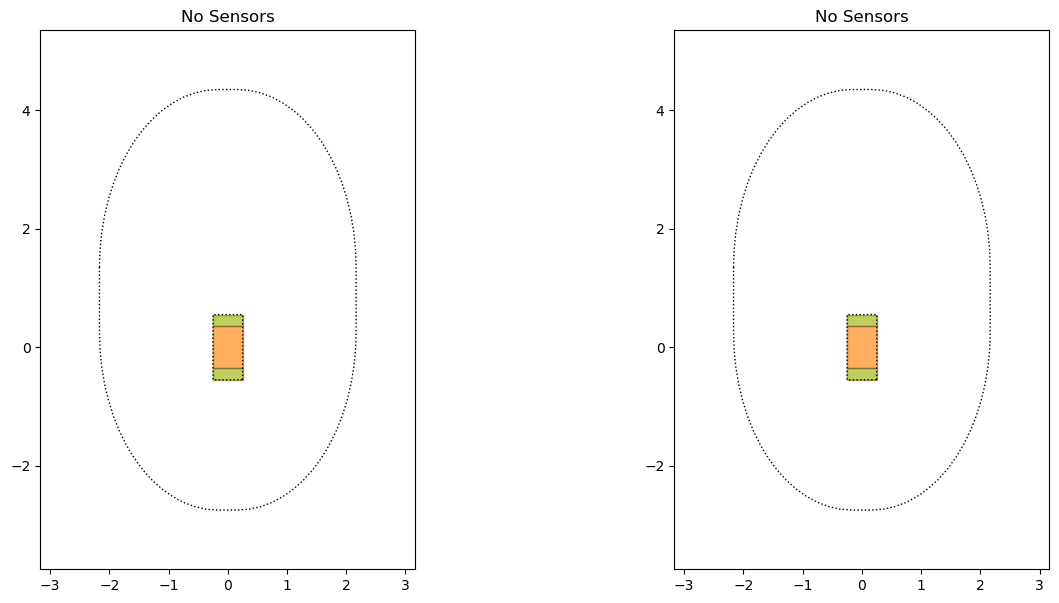

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7))

spot.plot_bot(show_constraint=True, title=f"No Sensors", ax=axes[0])
spot.plot_bot(show_constraint=True, title=f"No Sensors", ax=axes[1])

fig.savefig(f"./_output/{bot_name.lower()}/{timestamp}_botcompare_none.png")

In [ ]:
from pymoo.algorithms.moo.nsga2 import NSGA2, RankAndCrowdingSurvival
from pymoo.core.mixed import MixedVariableGA
from pymoo.optimize import minimize
from pymoo.visualization.scatter import Scatter
from pymoo.operators.crossover.sbx import SBX
from pymoo.operators.mutation.pm import PM
from pymoo.operators.sampling.rnd import FloatRandomSampling
import dill

max_sensors = 9
p_no_sensor = 0.1

problem = SensorPkgOptimization(spot, sensor_options, max_sensors)

p_sensor_probs = [p_no_sensor] + [(1-p_no_sensor)/(len(sensor_options)-1)]*(len(sensor_options)-1)

print("Probabilities:", p_sensor_probs)
print("Sum to:", sum(p_sensor_probs))

algorithm = MixedVariableGA(
    pop_size=500,
    n_offsprings=150,
    sampling=CustomSensorPkgRandomSampling(p=p_sensor_probs),
    survival=RankAndCrowdingSurvival(),
    eliminate_duplicates=MixedVariableDuplicateElimination(),
)

with open(f'./_output/{bot_name.lower()}/{timestamp}_problem.pkl', 'wb') as f:
    dill.dump(problem, f)

Probabilities: [0.1, 0.3, 0.3, 0.3]
Sum to: 1.0


In [6]:
plt.style.use('ggplot')
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['font.family'] = 'Arial' 

In [7]:
res = minimize(problem,
               algorithm,
               ('n_gen', 300),
               seed=1,
               verbose=True)

pareto_front = problem.pareto_front(use_cache=True, flatten=False)

n_gen  |  n_eval  |     f_avg     |     f_min    
     1 |      500 |  0.0676693232 |  0.1545167354
     2 |      650 |  0.0663296151 |  0.1545167354
     3 |      800 |  0.0658442351 |  0.1545167354
     4 |      950 |  0.0652213517 |  0.1545167354
     5 |     1100 |  0.0652519934 |  0.1545167354
     6 |     1250 |  0.0666697046 |  0.1545167354
     7 |     1400 |  0.0682026757 |  0.1545167354
     8 |     1550 |  0.0707590712 |  0.1545167354
     9 |     1700 |  0.0714436342 |  0.1545167354
    10 |     1850 |  0.0718954951 |  0.1545167354
    11 |     2000 |  0.0722687427 |  0.1545167354
    12 |     2150 |  0.0723525006 |  0.1545167354
    13 |     2300 |  0.0735893246 |  0.1545167354
    14 |     2450 |  0.0761412791 |  0.1545167354
    15 |     2600 |  0.0767850420 |  0.1560684502
    16 |     2750 |  0.0767513502 |  0.1560684502
    17 |     2900 |  0.0783844707 |  0.1560684502
    18 |     3050 |  0.0786520353 |  0.1560684502
    19 |     3200 |  0.0813322469 |  0.1560684502


In [8]:
import pandas as pd
import plotly.express as px

# Create a DataFrame from the results
df_results = pd.DataFrame(res.F, columns=['Perception Coverage', 'Cost'])
df_results['Perception Coverage'] = (1- df_results['Perception Coverage']) * 100
df_results['Index'] = df_results.index
df_results['Name'] = [f"Pkg Concept {i}" for i in df_results.index]
df_results['X'] = res.X
df_results['History'] = [None] * len(df_results)
df_results["Optimized"] = "Non-optimized"

## Calculate the (Unoptimized) Pareto Front

In [9]:
import numpy as np

# Example usage
ideal_point = np.array([0., 0.])  # Example ideal point
pareto_front, pareto_idx = get_pareto_front(df_results, x='Cost', y='Perception Coverage')
pareto_unoptimized_df = df_results.iloc[pareto_idx]

pareto_unoptimized_df

Perception Coverage     Cost  Index            Name  \
0             99.493624  10456.0      0   Pkg Concept 0   
3             21.642867    314.0      3   Pkg Concept 3   
4             40.114424    499.0      4   Pkg Concept 4   
9             52.915356    813.0      9   Pkg Concept 9   
18            56.110094    998.0     18  Pkg Concept 18   
11            64.029950   1127.0     11  Pkg Concept 11   
14            67.385731   1312.0     14  Pkg Concept 14   
13            72.792370   1441.0     13  Pkg Concept 13   
15            77.252369   1626.0     15  Pkg Concept 15   
19            79.476188   1940.0     19  Pkg Concept 19   
20            80.632246   2254.0     20  Pkg Concept 20   
21            84.215758   2310.0     21  Pkg Concept 21   
8             85.997959   2495.0      8   Pkg Concept 8   
6             86.155646   4914.0      6   Pkg Concept 6   
17            89.485929   5099.0     17  Pkg Concept 17   
16            92.991210   5228.0     16  Pkg Concept 16   
10            97.154946   5413.0     10  Pkg Concept 10   
12            97.206974   6355.0     12  Pkg Concept 12   
5             97.834524   6725.0      5   Pkg Concept 5   
7             99.233260   9200.0      7   Pkg Concept 7   
22            99.270414   9514.0     22  Pkg Concept 22   
23            99.447164   9828.0     23  Pkg Concept 23   
24            99.482225  10142.0     24  Pkg Concept 24   
0             99.493624  10456.0      0   Pkg Concept 0   

                                                    X History      Optimized  
0   {'s0_type': 3, 's1_type': 1, 's2_type': 1, 's3...    None  Non-optimized  
3   {'s0_type': 0, 's1_type': 0, 's2_type': 0, 's3...    None  Non-optimized  
4   {'s0_type': 0, 's1_type': 2, 's2_type': 0, 's3...    None  Non-optimized  
9   {'s0_type': 0, 's1_type': 0, 's2_type': 0, 's3...    None  Non-optimized  
18  {'s0_type': 2, 's1_type': 2, 's2_type': 0, 's3...    None  Non-optimized  
11  {'s0_type': 0, 's1_type': 1, 's2_type': 2, 's3...    None  Non-optimized  
14  {'s0_type': 2, 's1_type': 2, 's2_type': 1, 's3...    None  Non-optimized  
13  {'s0_type': 2, 's1_type': 1, 's2_type': 0, 's3...    None  Non-optimized  
15  {'s0_type': 2, 's1_type': 0, 's2_type': 1, 's3...    None  Non-optimized  
19  {'s0_type': 2, 's1_type': 1, 's2_type': 2, 's3...    None  Non-optimized  
20  {'s0_type': 2, 's1_type': 1, 's2_type': 2, 's3...    None  Non-optimized  
21  {'s0_type': 2, 's1_type': 2, 's2_type': 2, 's3...    None  Non-optimized  
8   {'s0_type': 2, 's1_type': 2, 's2_type': 2, 's3...    None  Non-optimized  
6   {'s0_type': 0, 's1_type': 1, 's2_type': 0, 's3...    None  Non-optimized  
17  {'s0_type': 0, 's1_type': 2, 's2_type': 0, 's3...    None  Non-optimized  
16  {'s0_type': 0, 's1_type': 0, 's2_type': 1, 's3...    None  Non-optimized  
10  {'s0_type': 1, 's1_type': 0, 's2_type': 0, 's3...    None  Non-optimized  
12  {'s0_type': 1, 's1_type': 2, 's2_type': 1, 's3...    None  Non-optimized  
5   {'s0_type': 2, 's1_type': 1, 's2_type': 2, 's3...    None  Non-optimized  
7   {'s0_type': 0, 's1_type': 0, 's2_type': 3, 's3...    None  Non-optimized  
22  {'s0_type': 3, 's1_type': 0, 's2_type': 1, 's3...    None  Non-optimized  
23  {'s0_type': 3, 's1_type': 0, 's2_type': 1, 's3...    None  Non-optimized  
24  {'s0_type': 3, 's1_type': 1, 's2_type': 1, 's3...    None  Non-optimized  
0   {'s0_type': 3, 's1_type': 1, 's2_type': 1, 's3...    None  Non-optimized

In [10]:
import datetime
df_results.to_pickle(f"./_output/{bot_name.lower()}/{timestamp}_df_unopt.pkl")

# Run the single-objective optimization

  0%|          | 0/24 [00:00<?, ?it/s]

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)
/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning: delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.
  self.H.update(delta_x, delta_g)


/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:316: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:6: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_funct

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.



/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the ap

/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.



/var/folders/wc/xsxjcsy91wl6d95rczwlspg80000gn/T/ipykernel_34256/3174431678.py:21: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



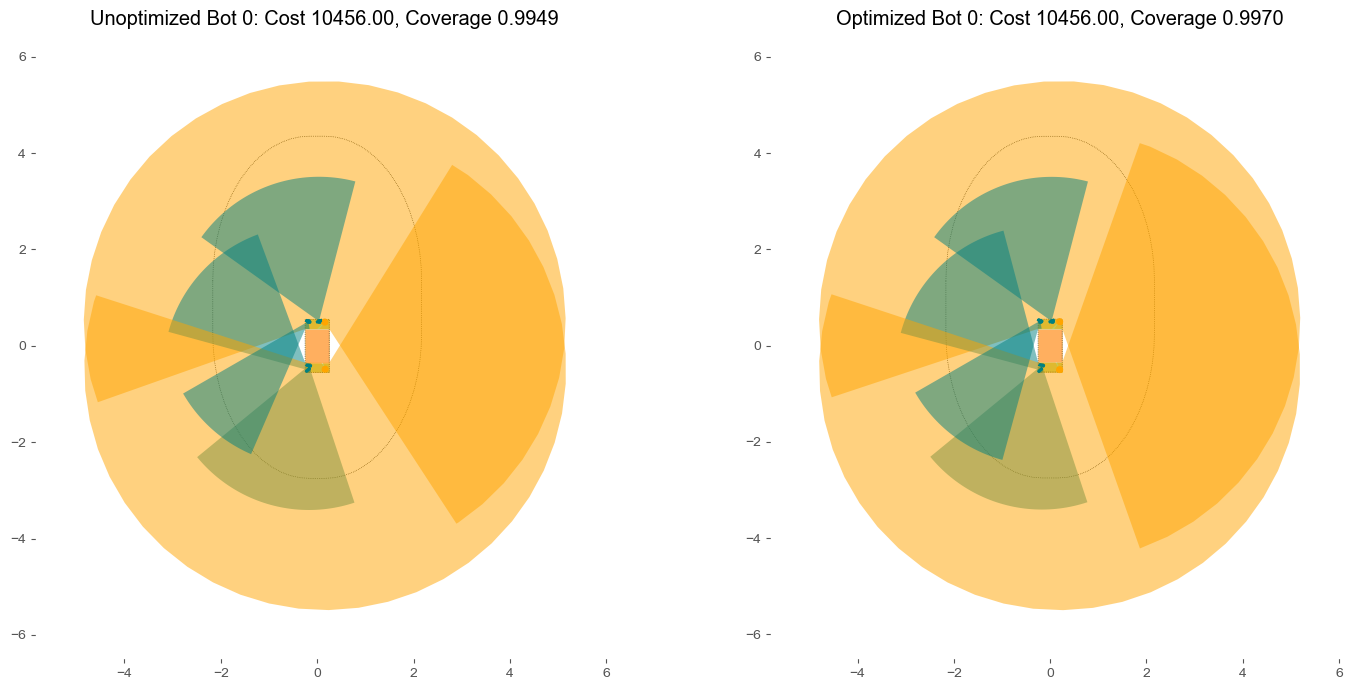

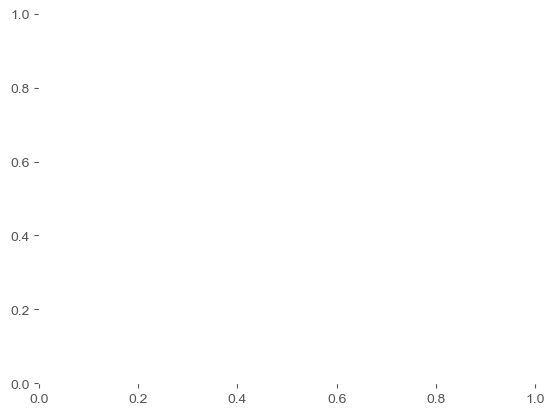

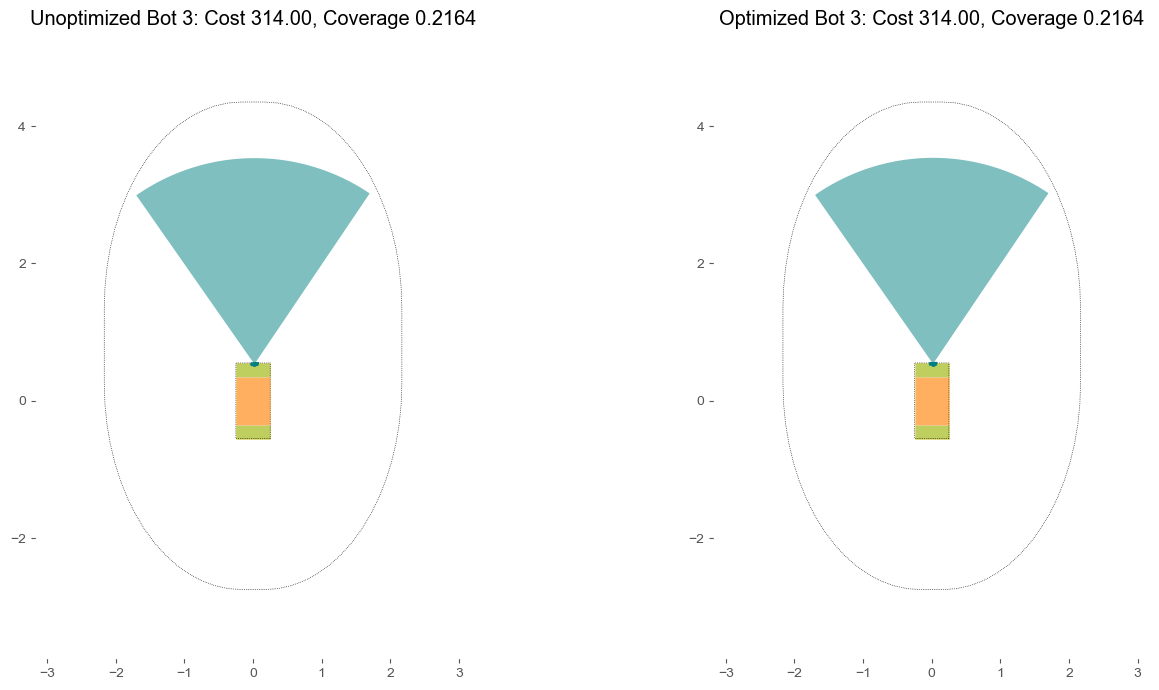

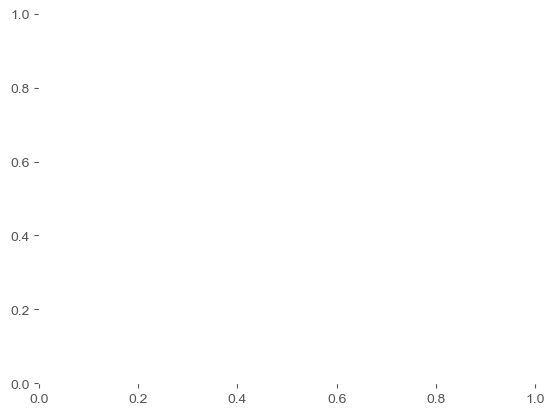

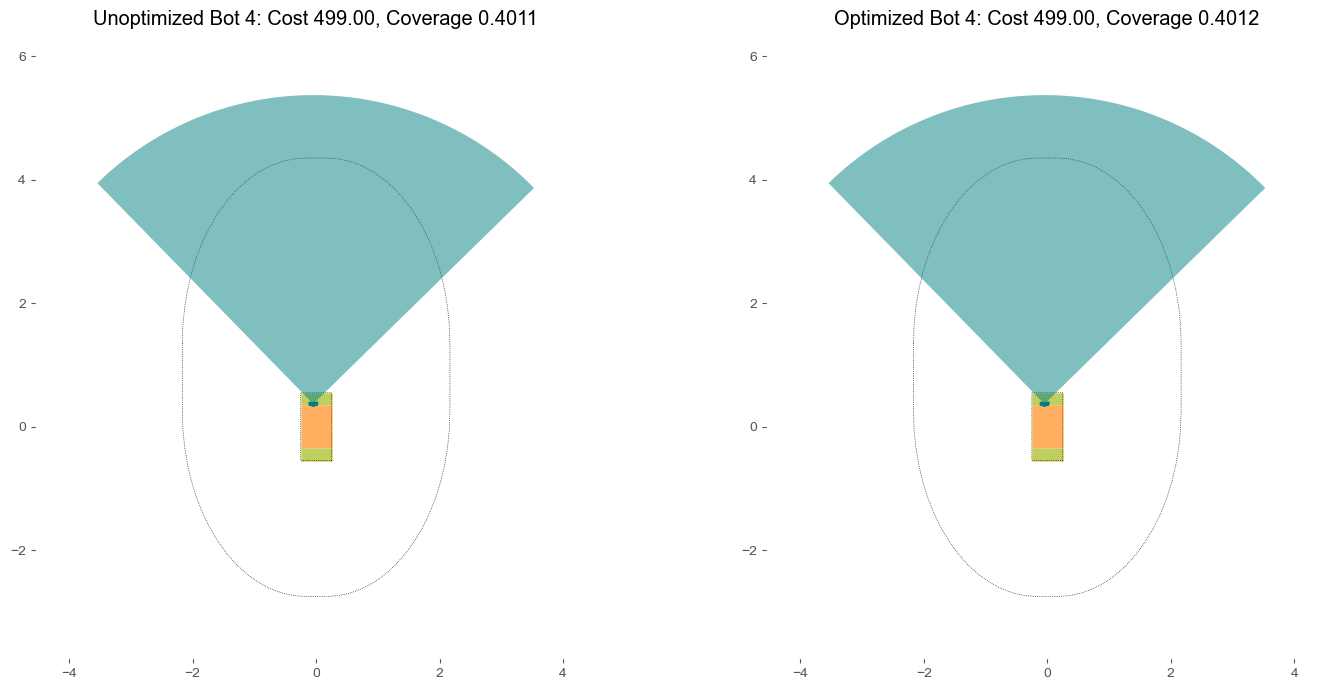

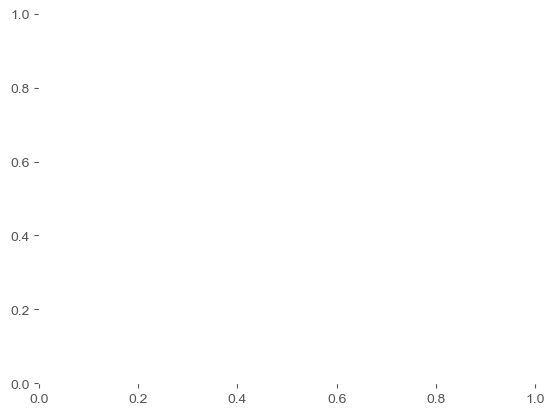

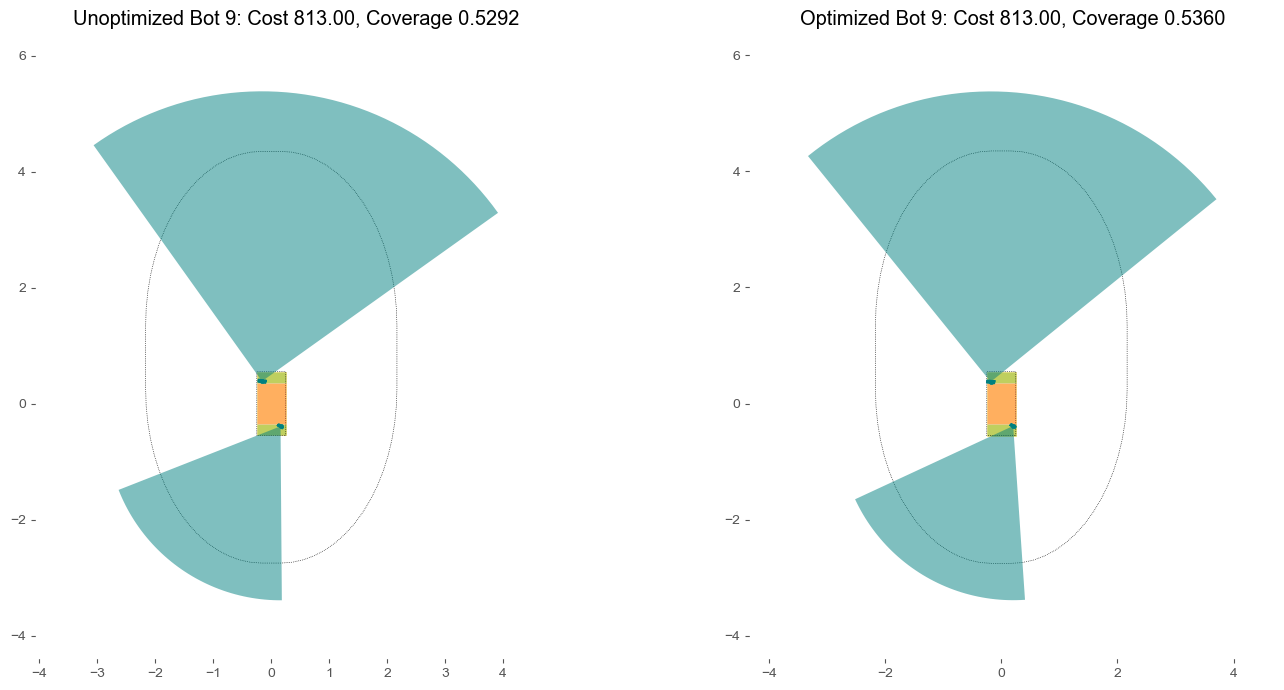

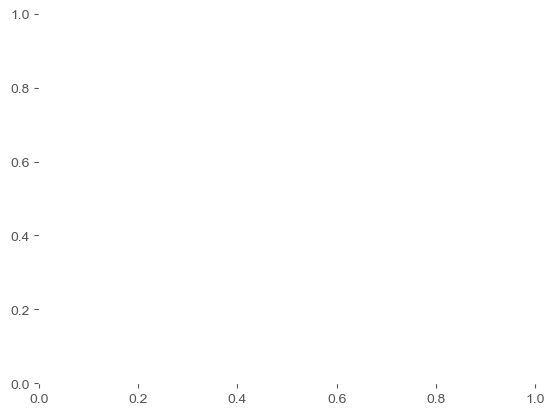

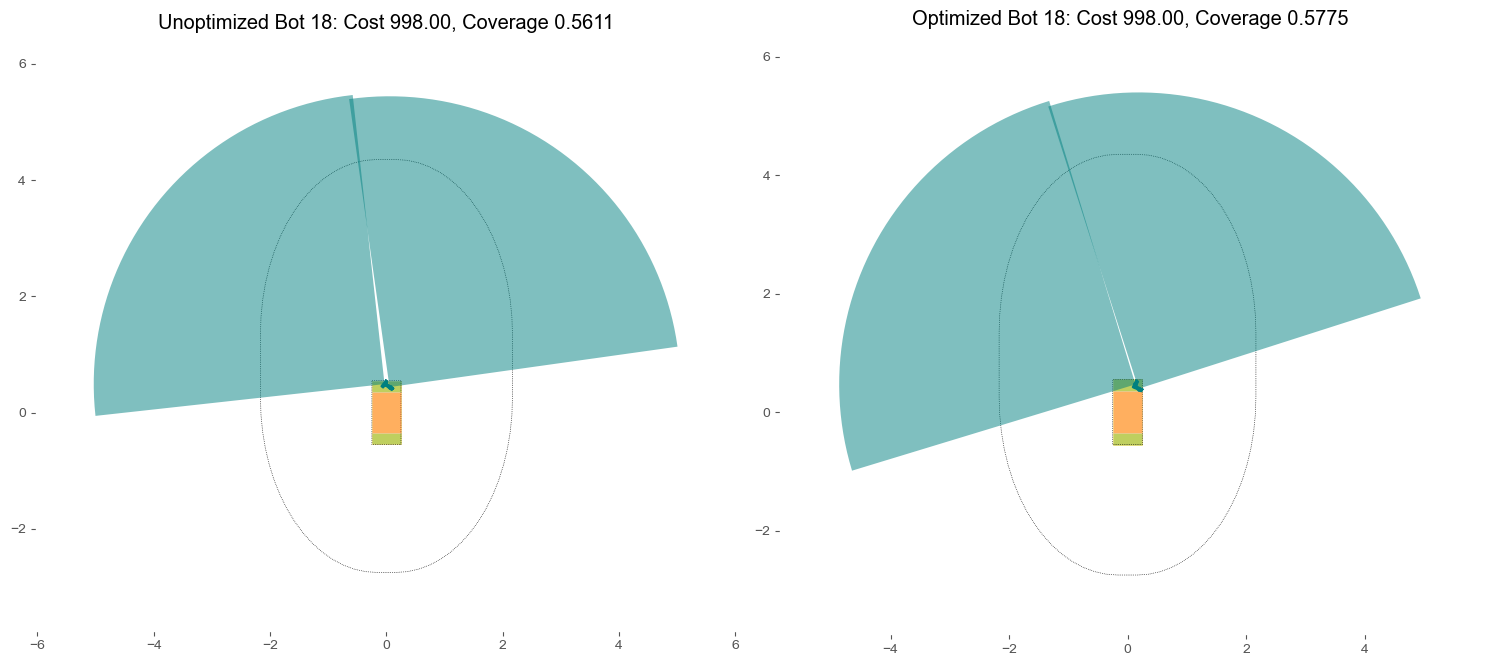

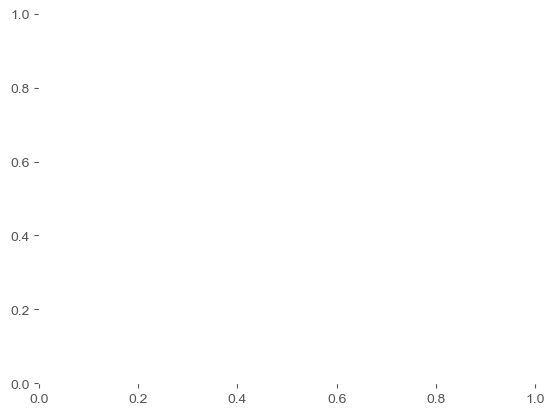

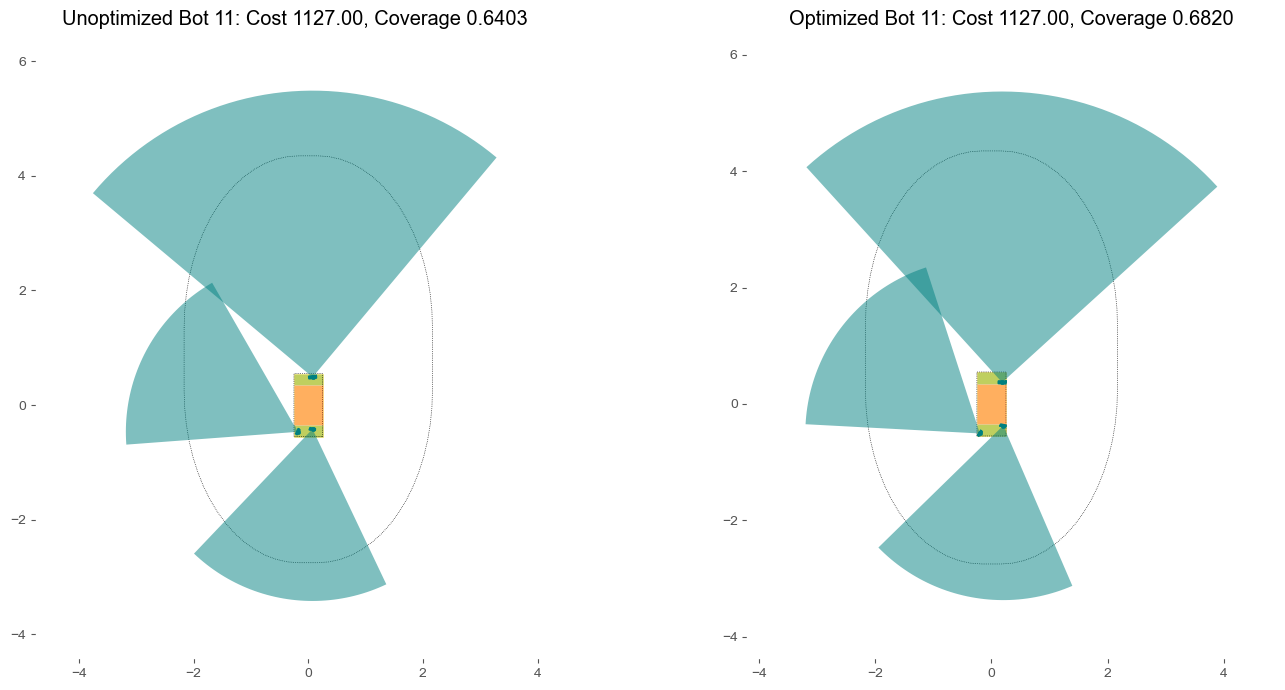

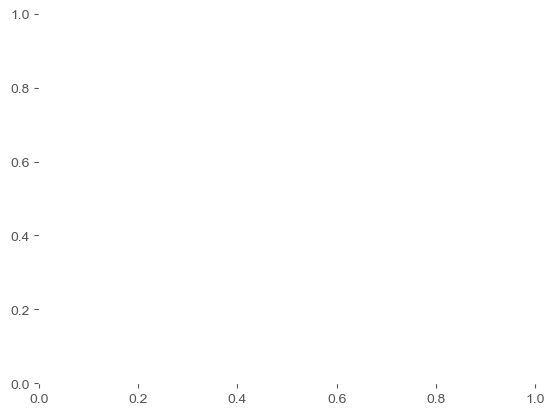

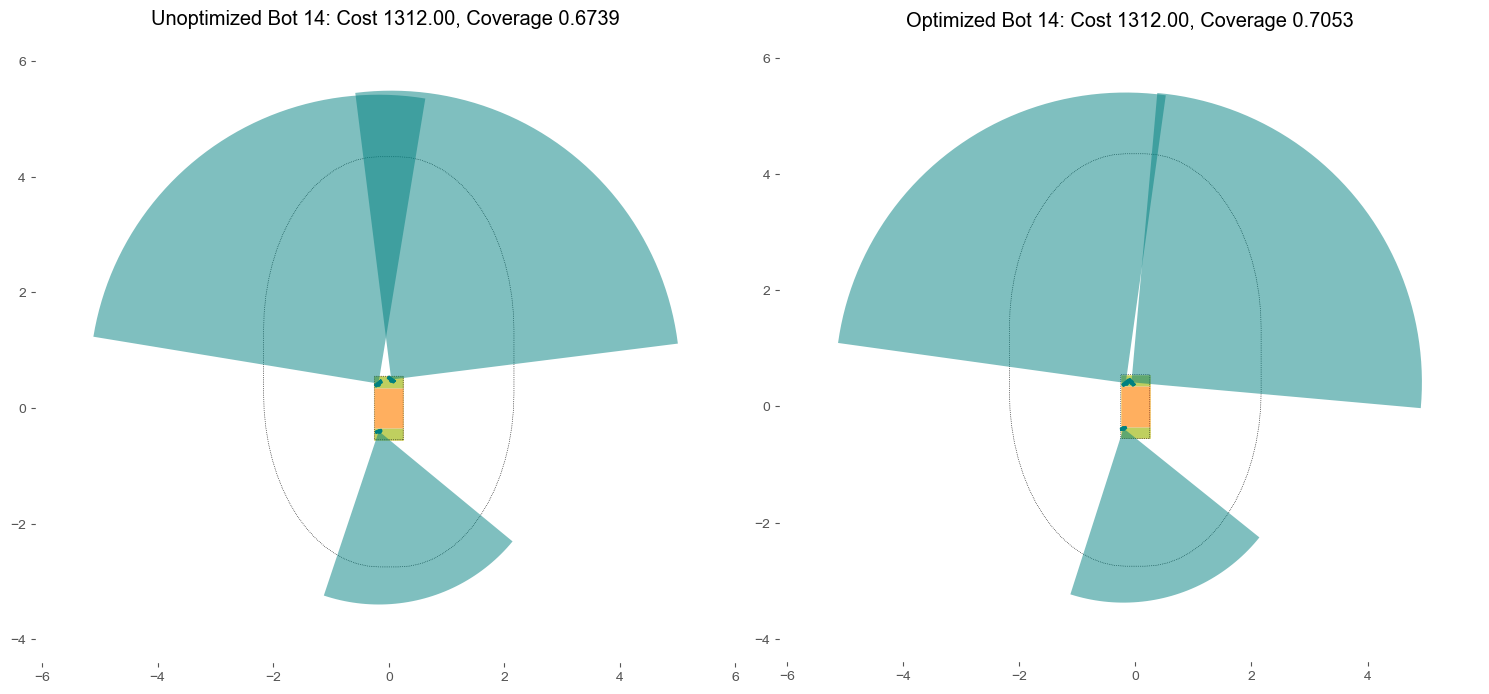

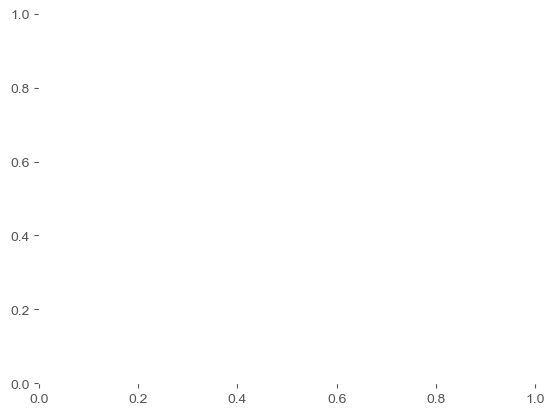

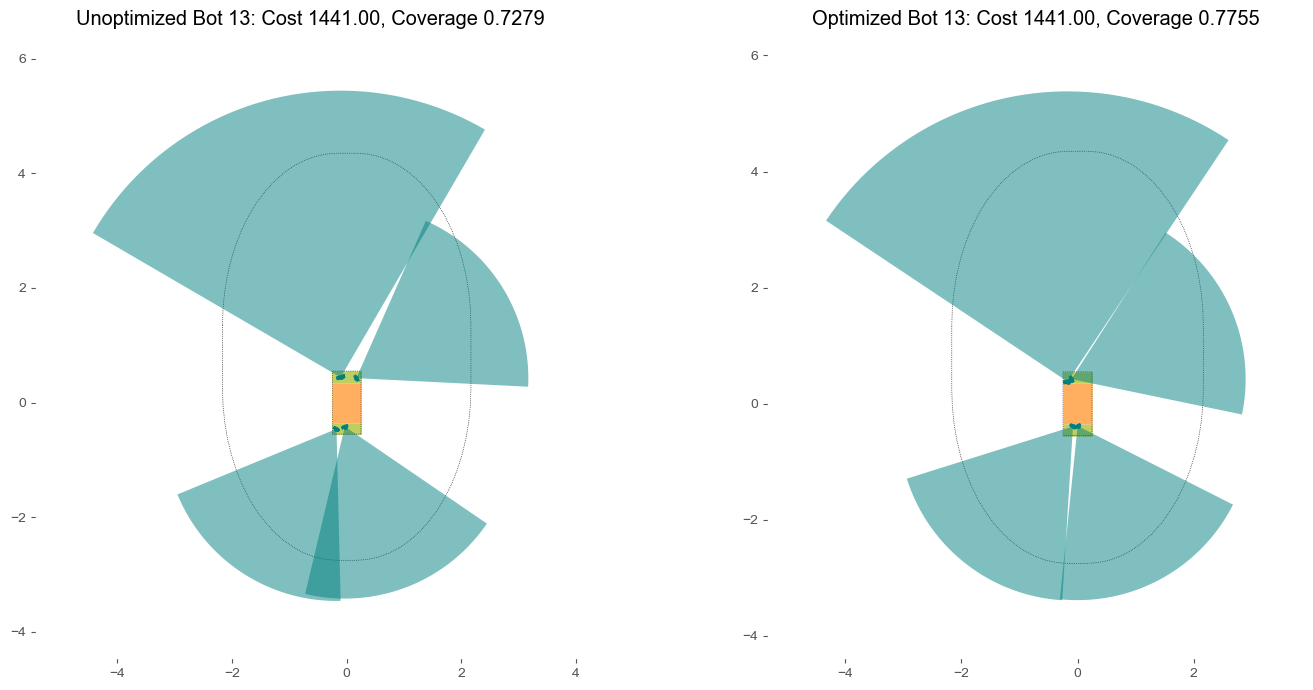

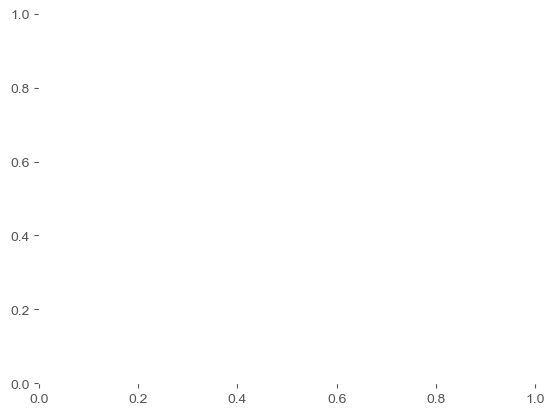

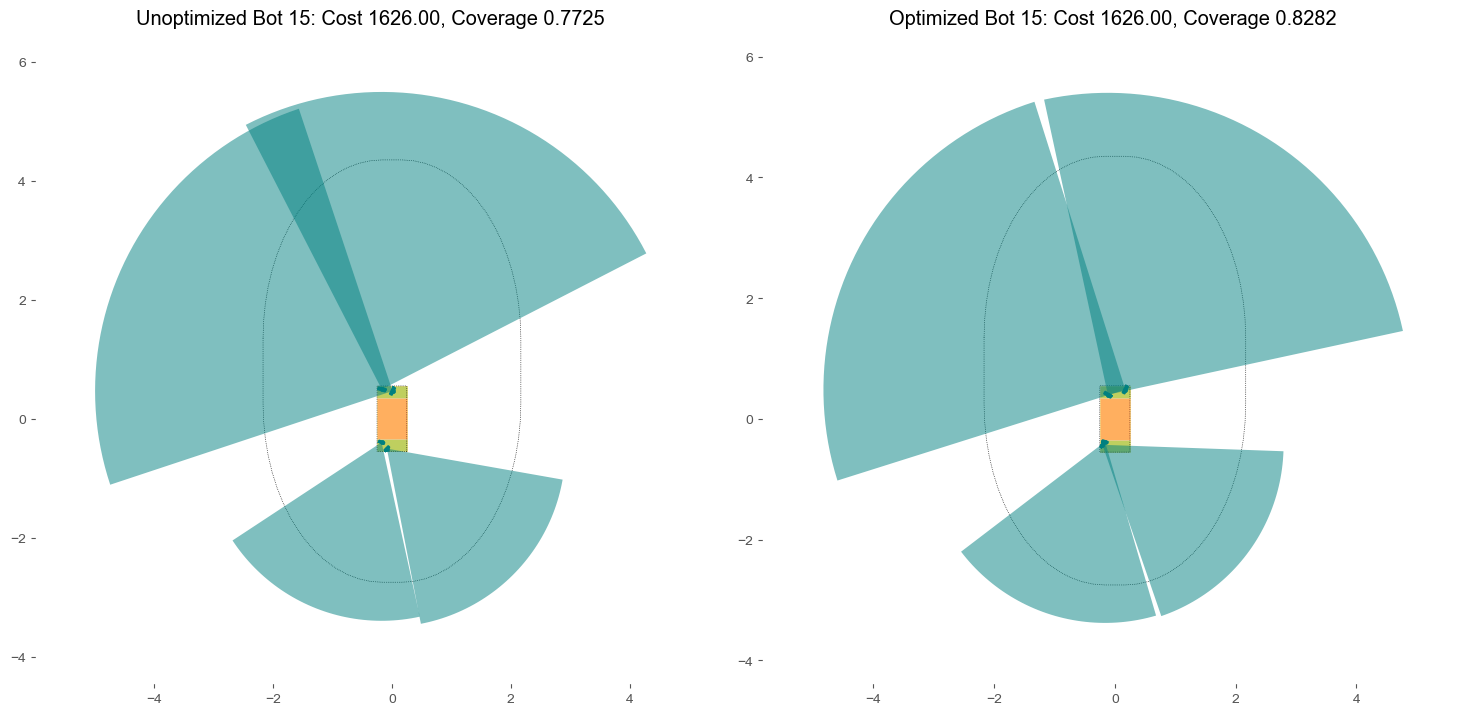

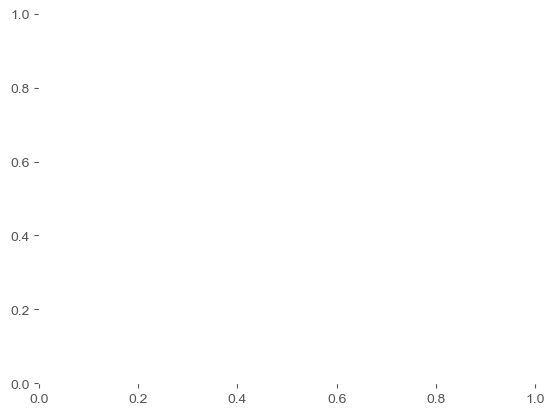

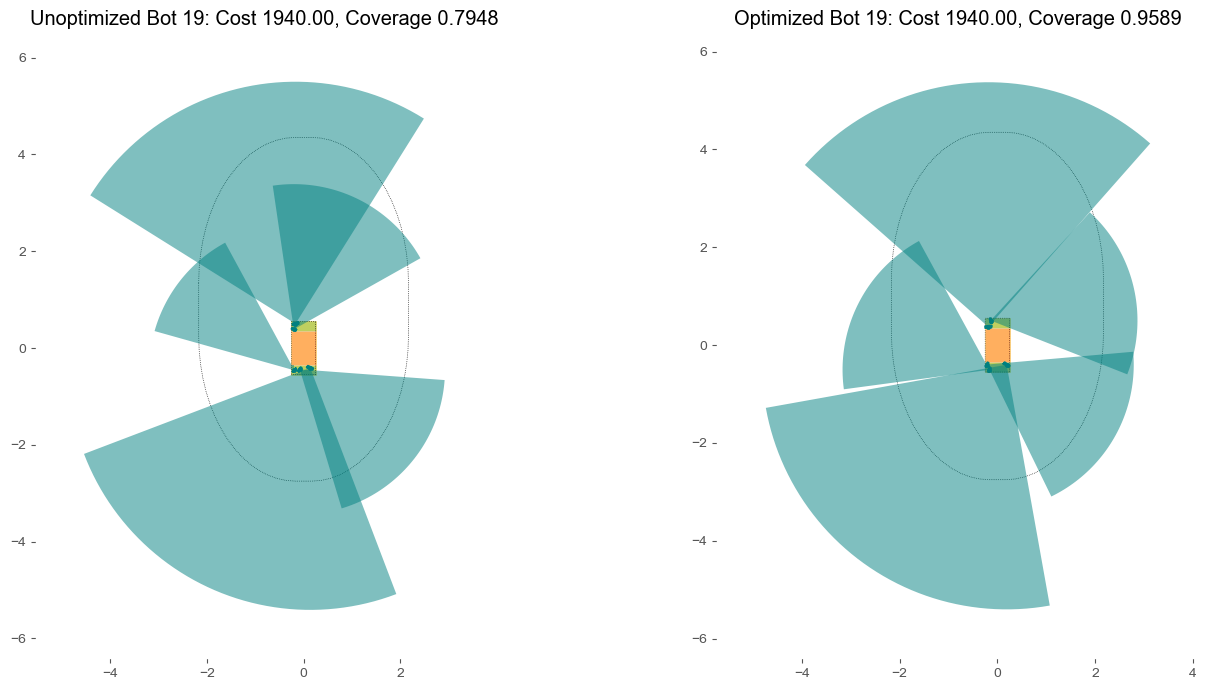

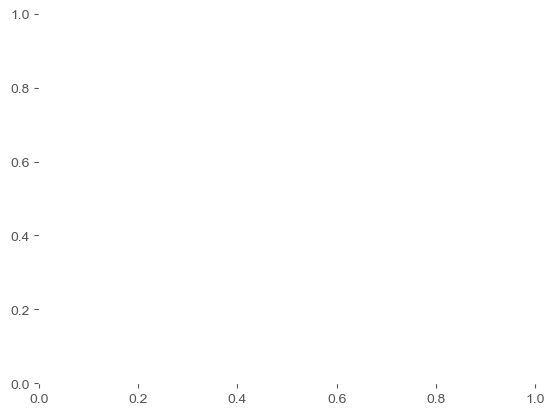

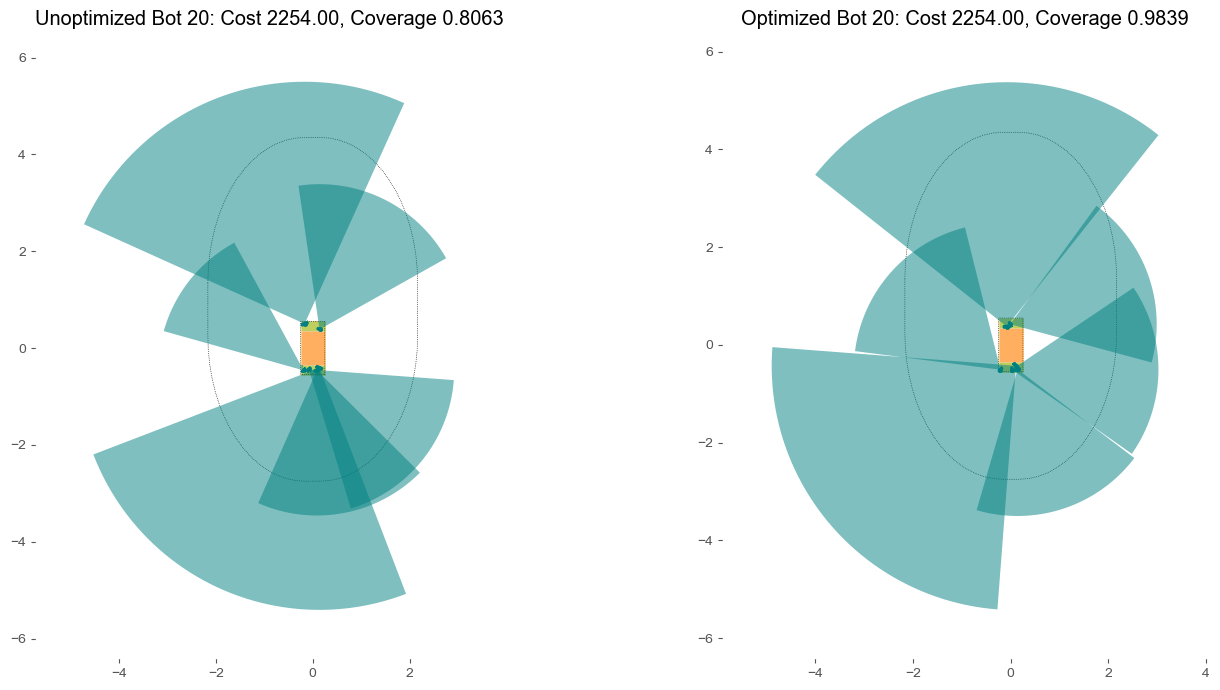

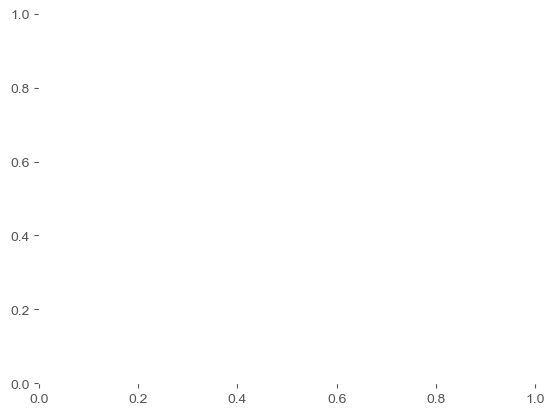

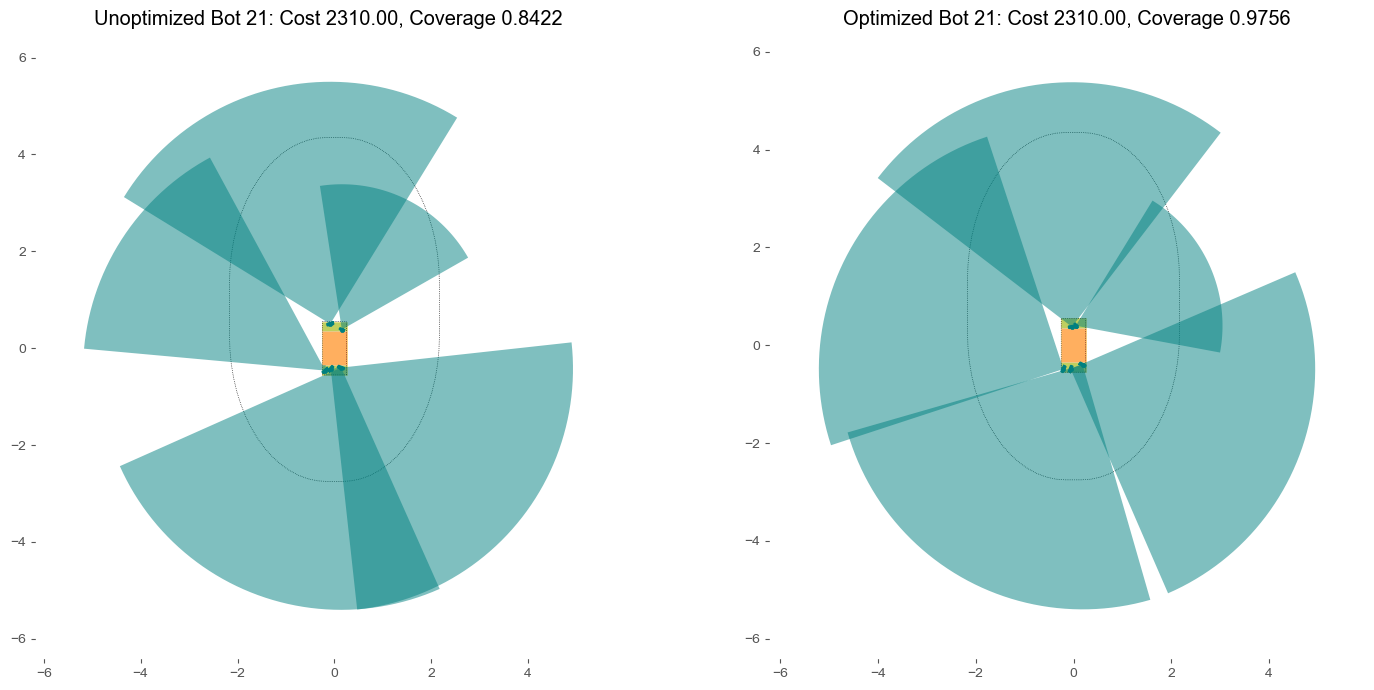

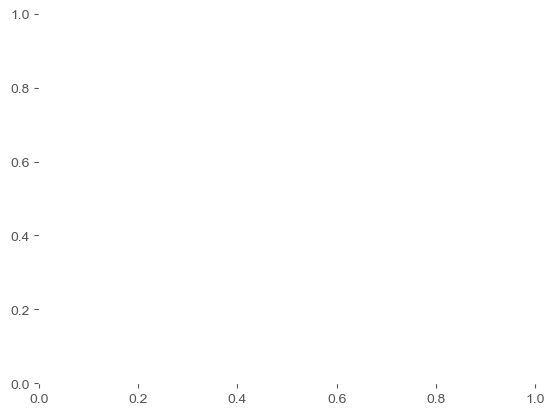

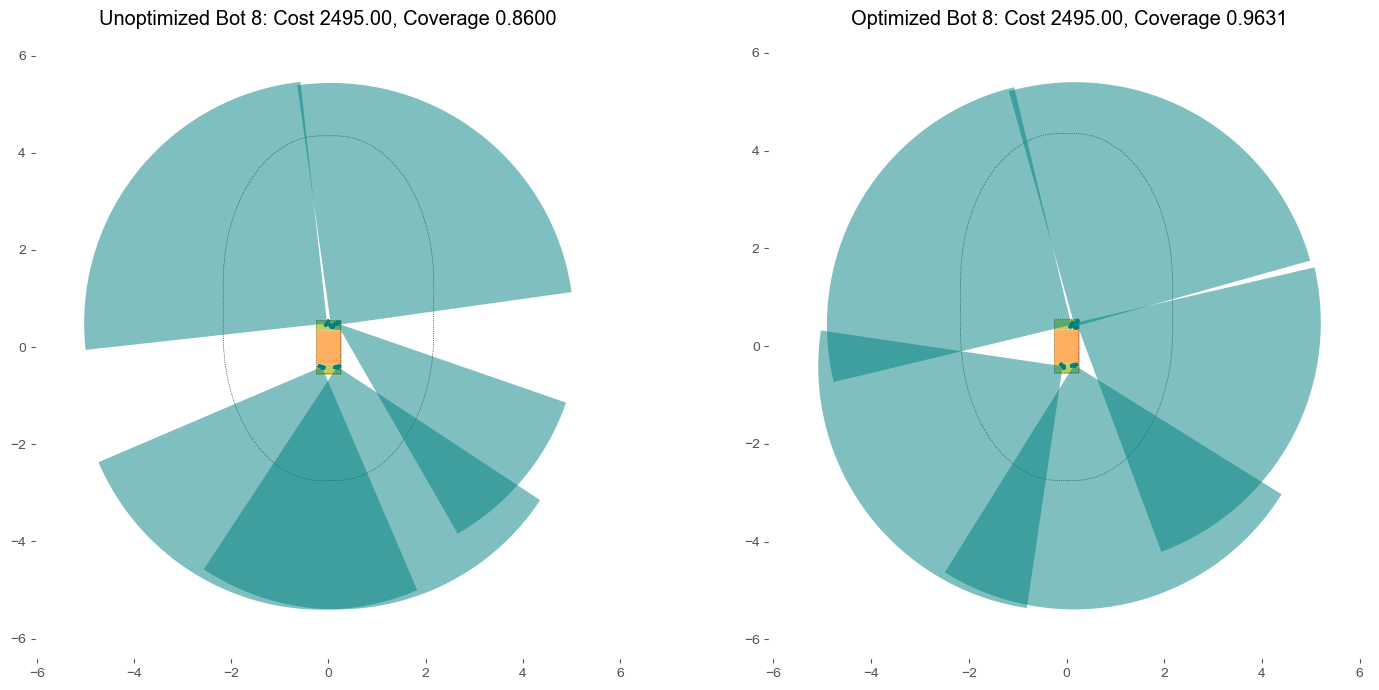

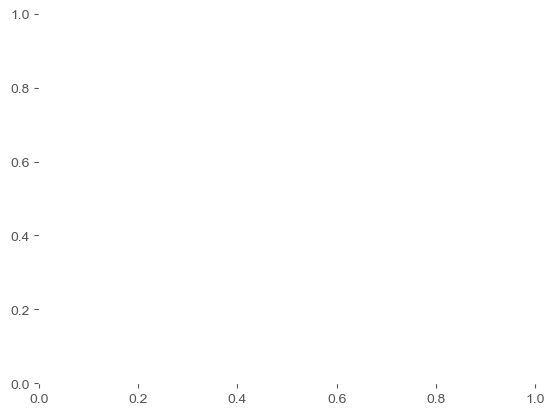

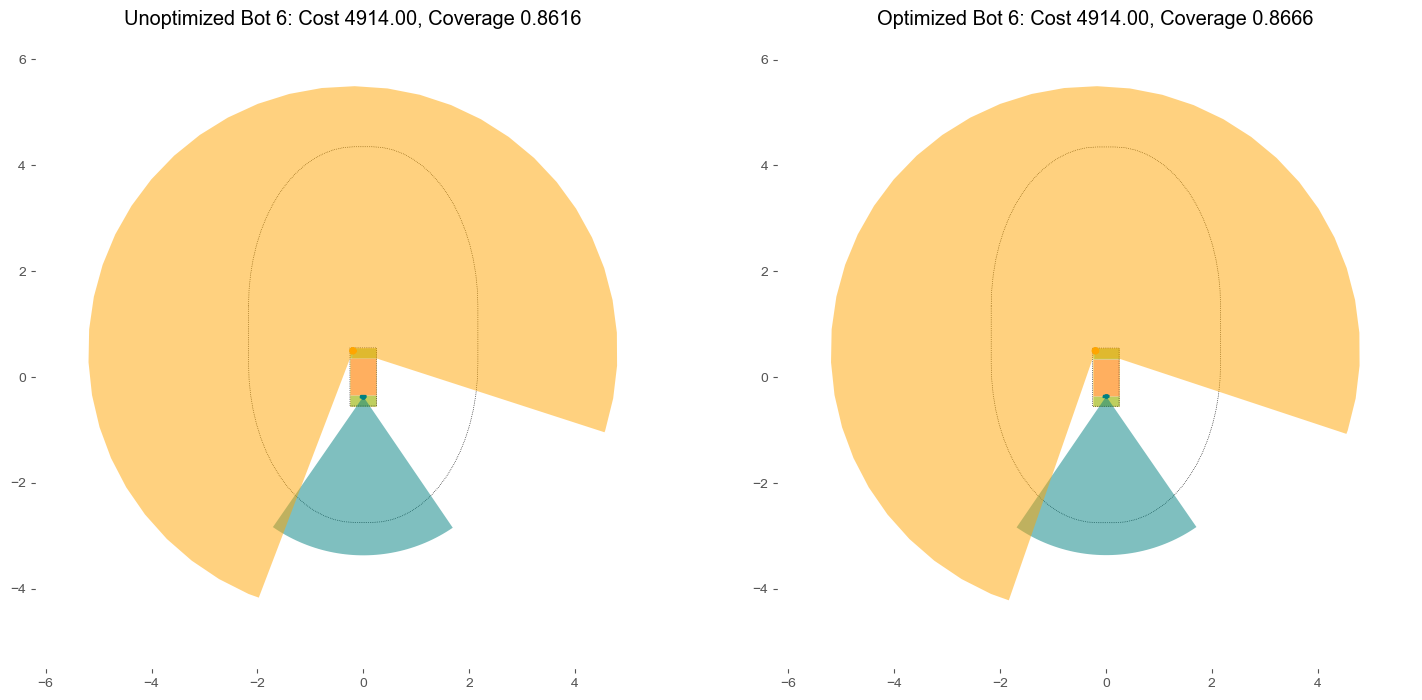

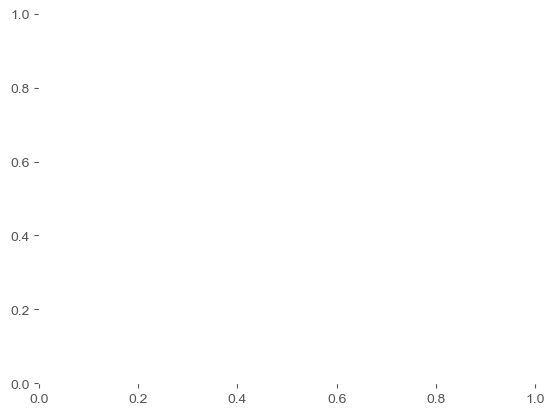

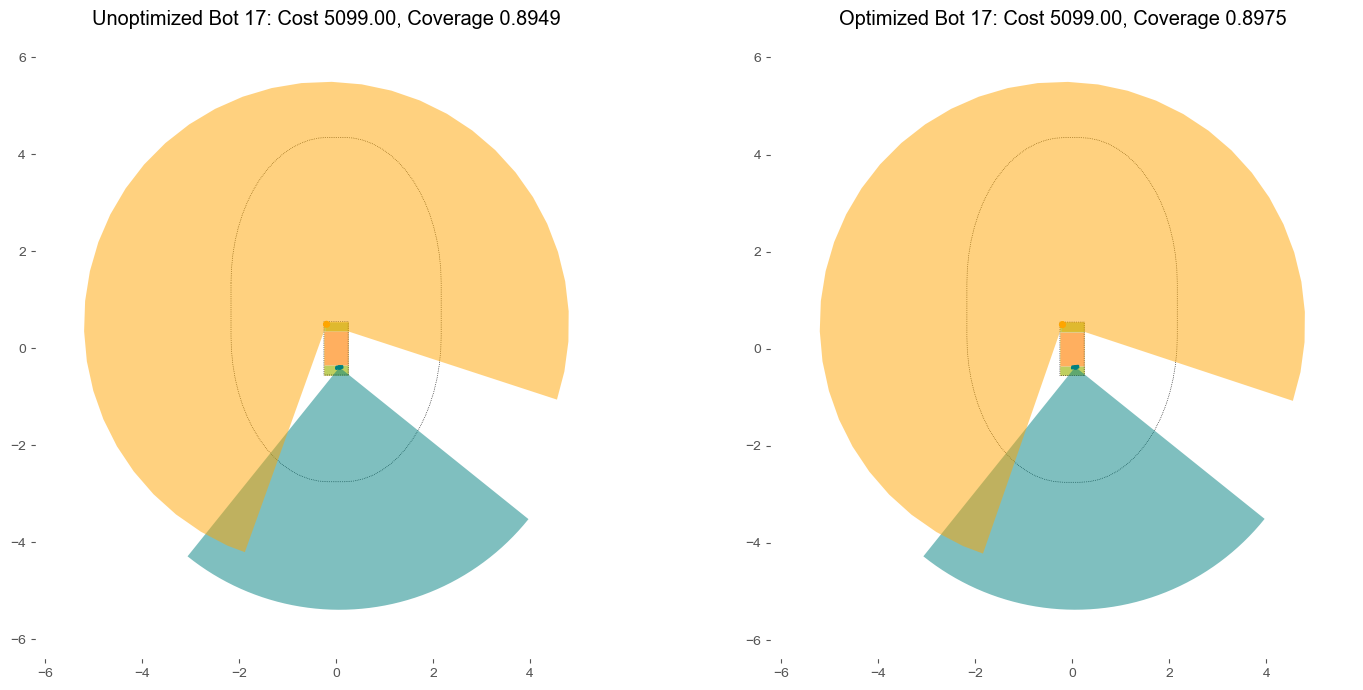

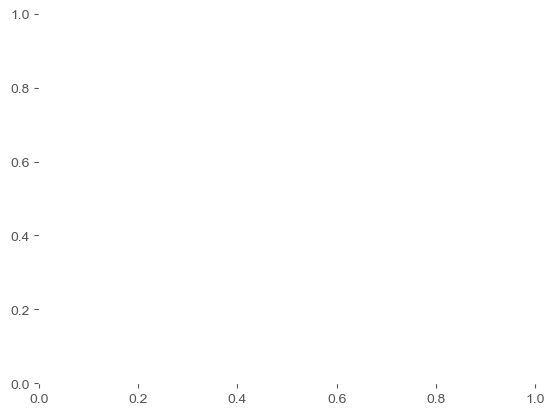

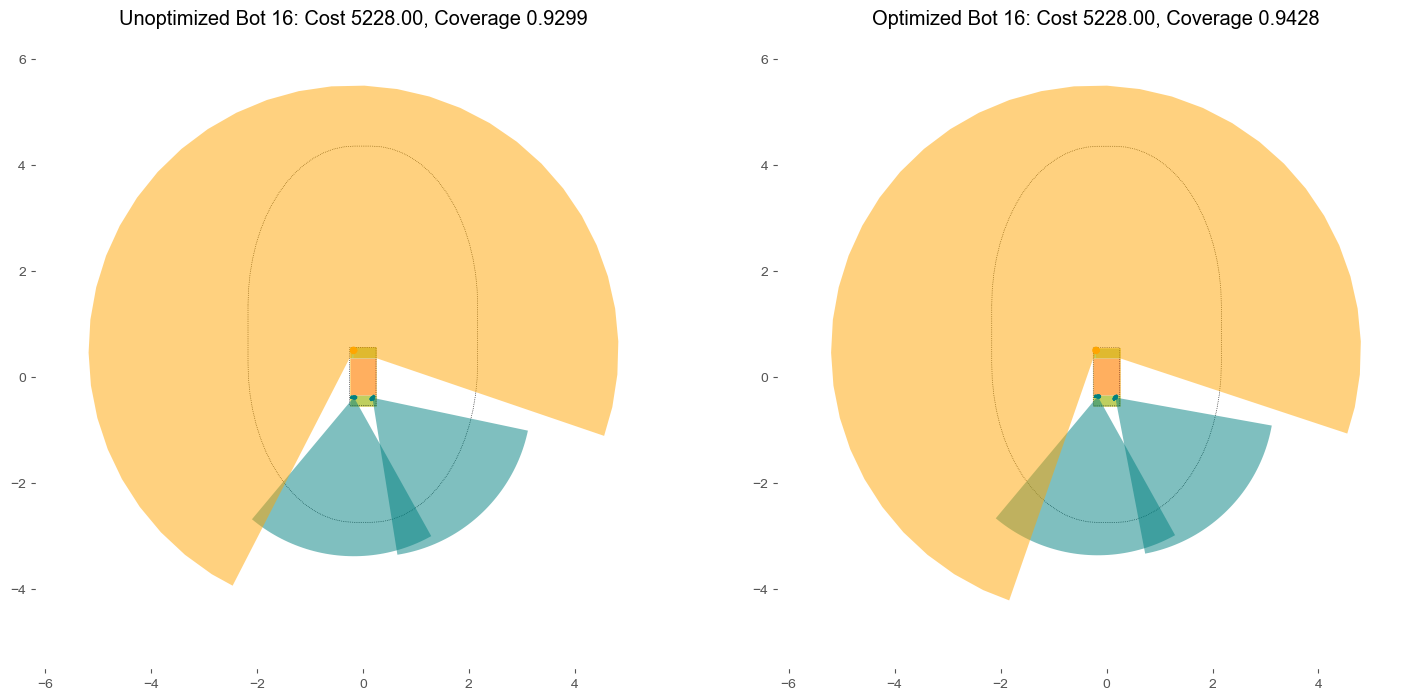

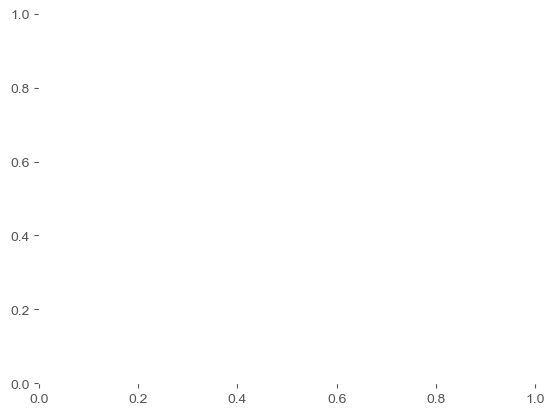

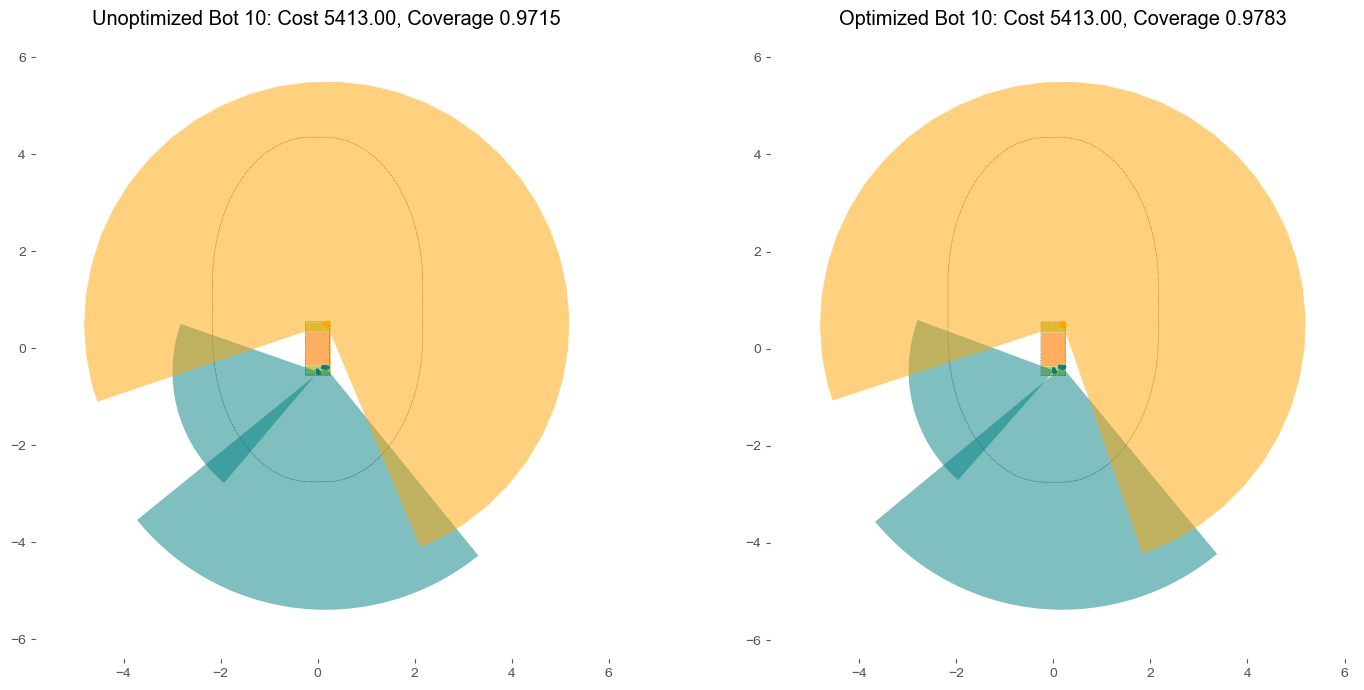

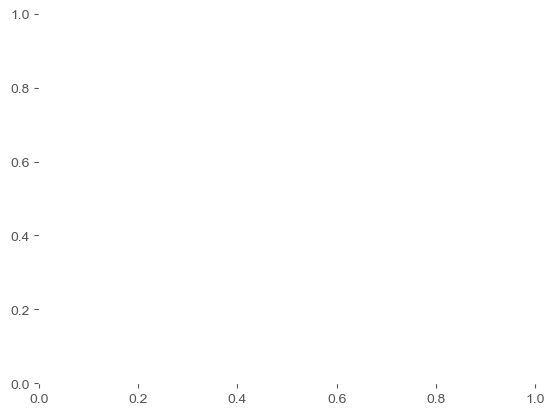

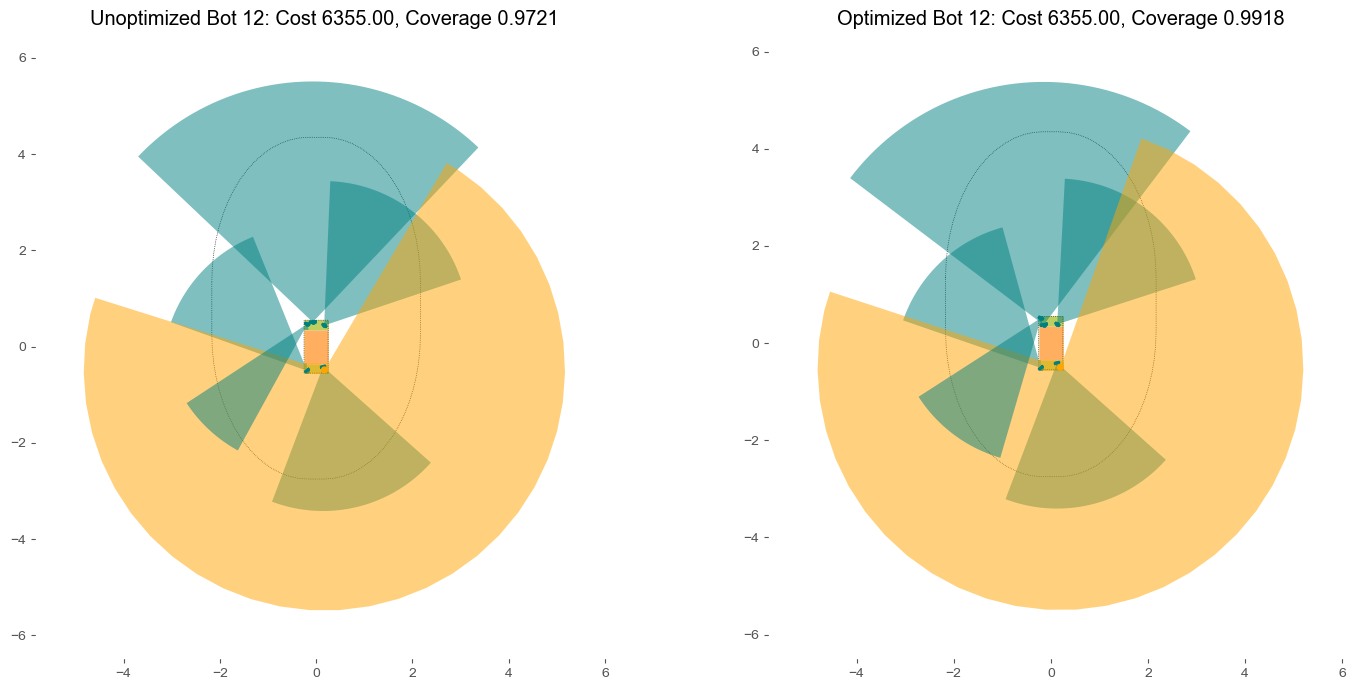

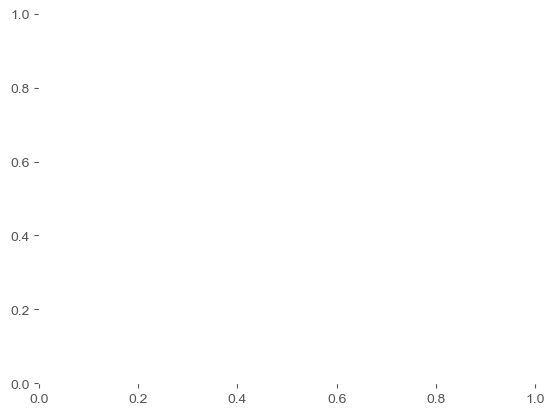

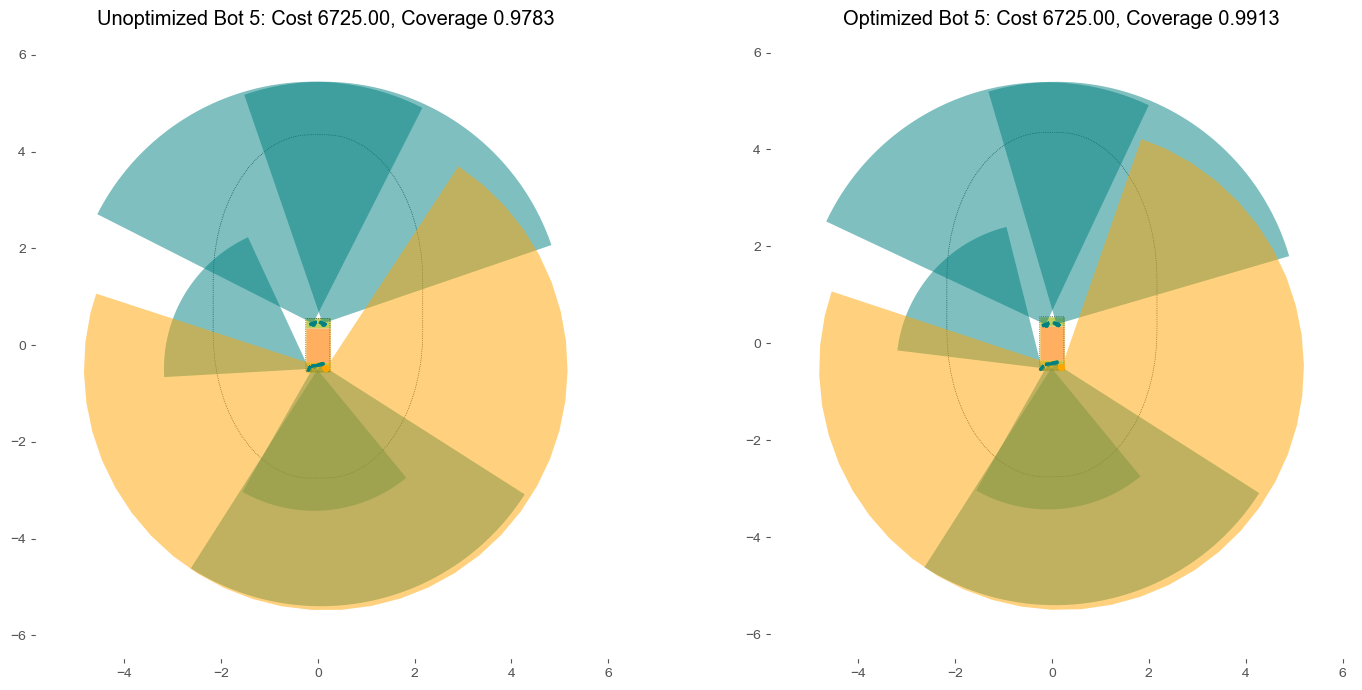

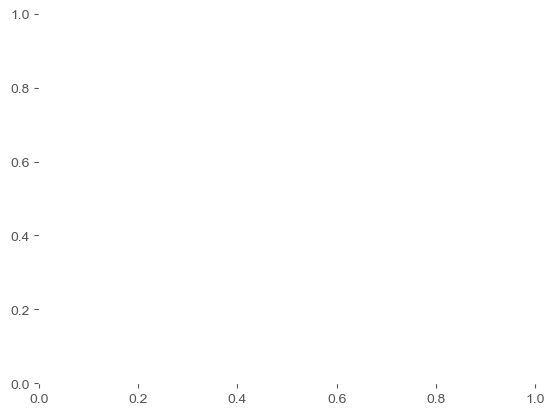

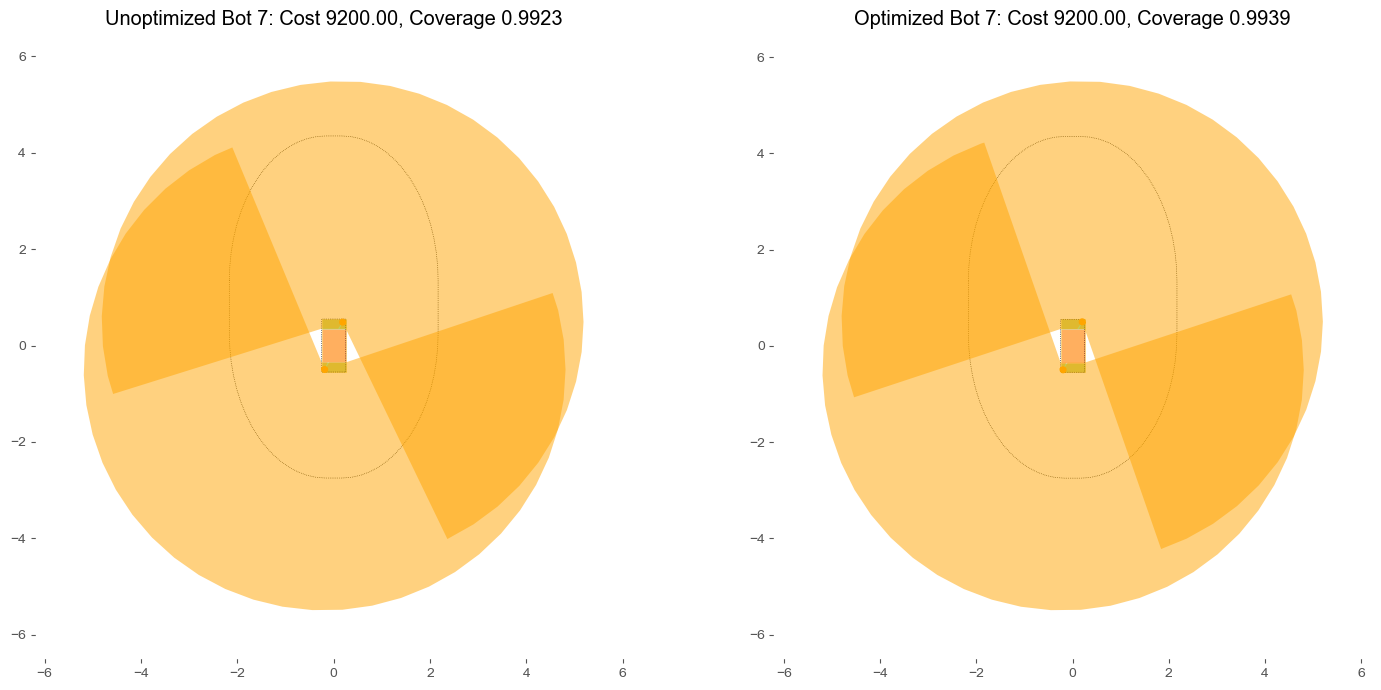

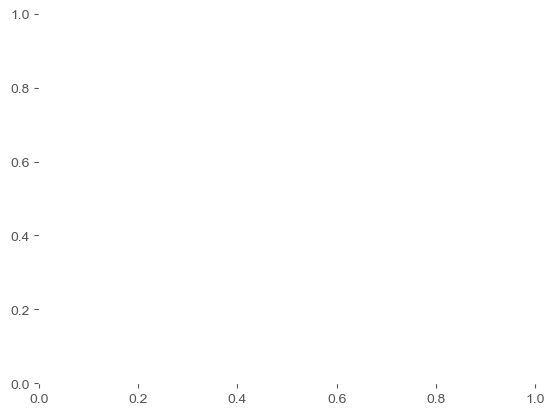

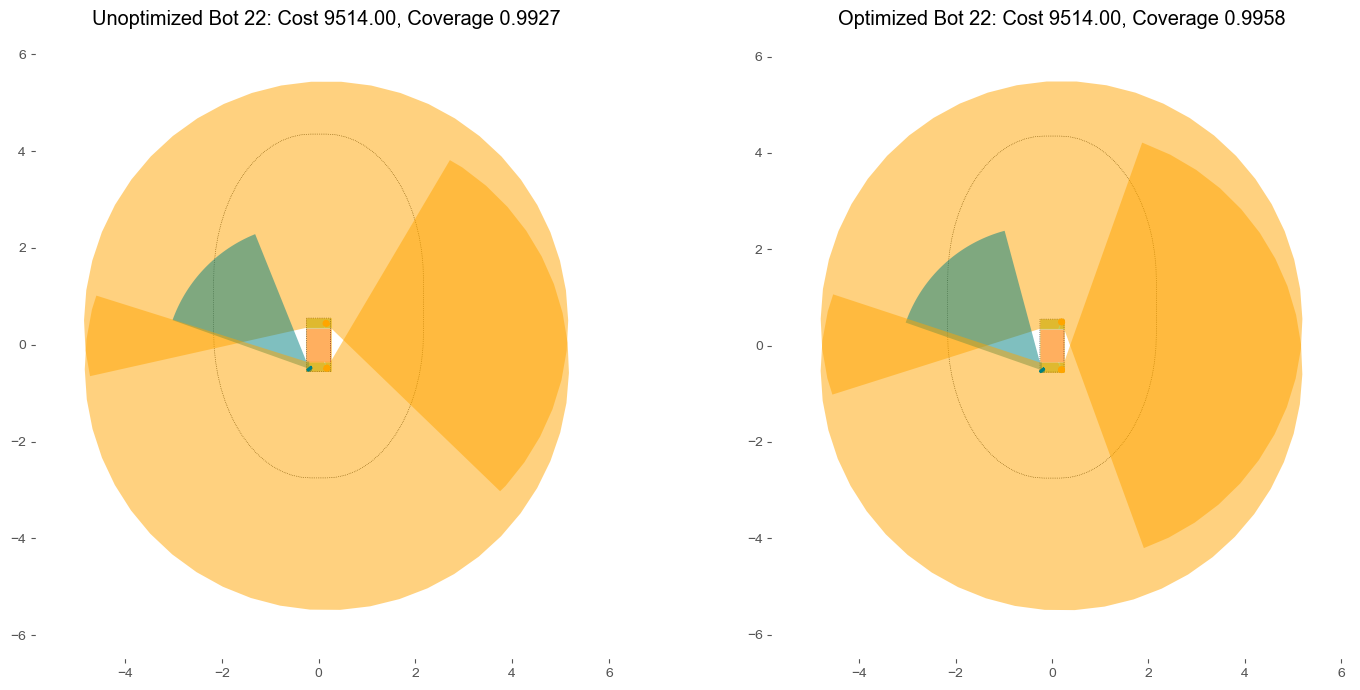

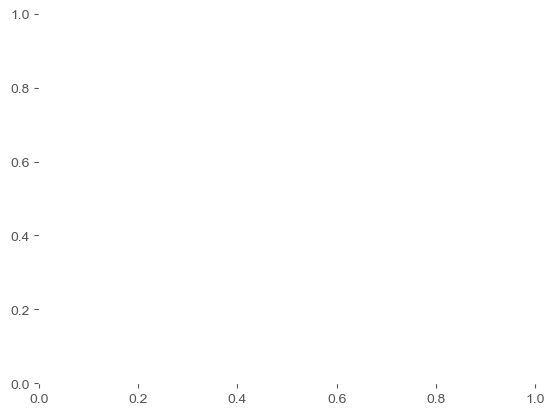

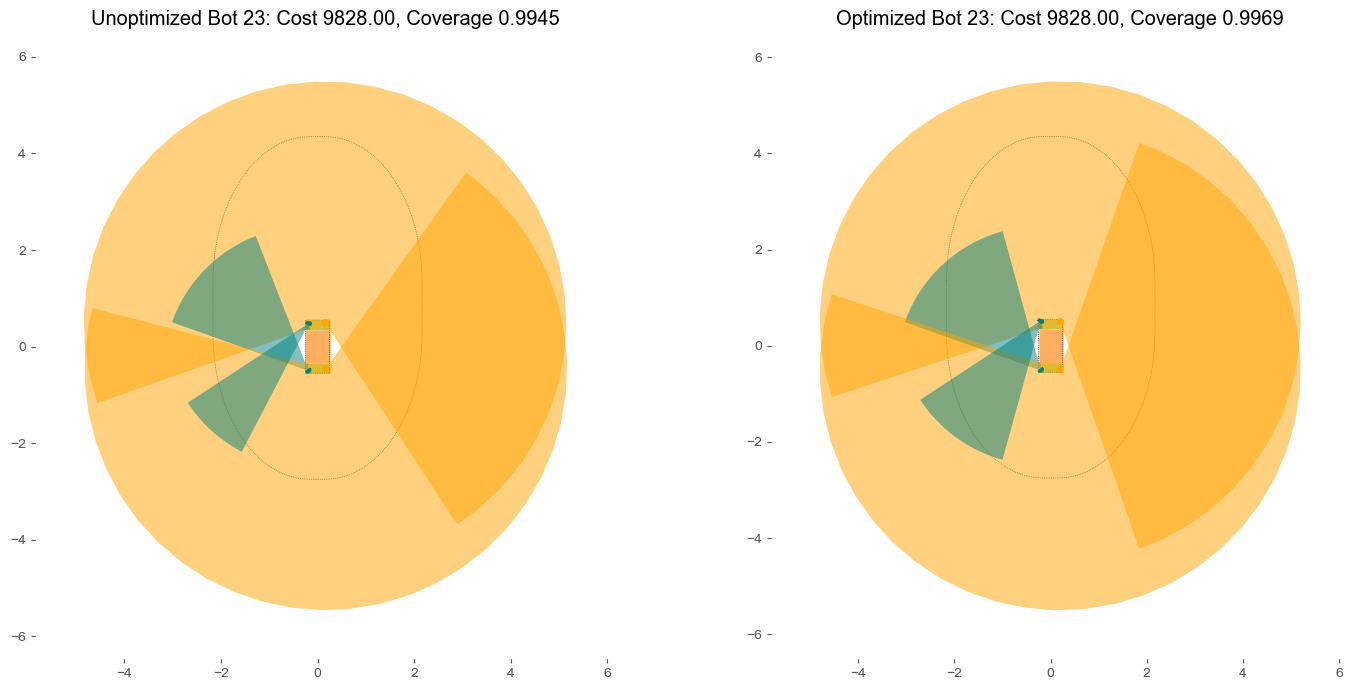

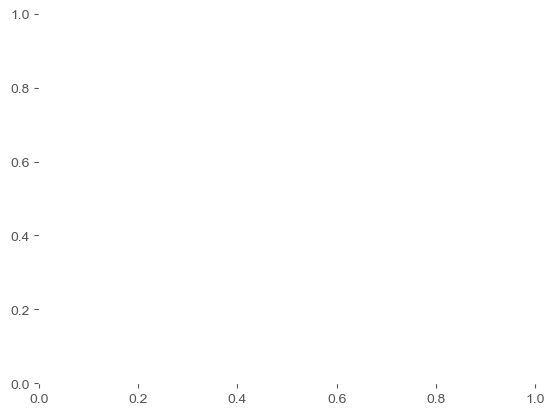

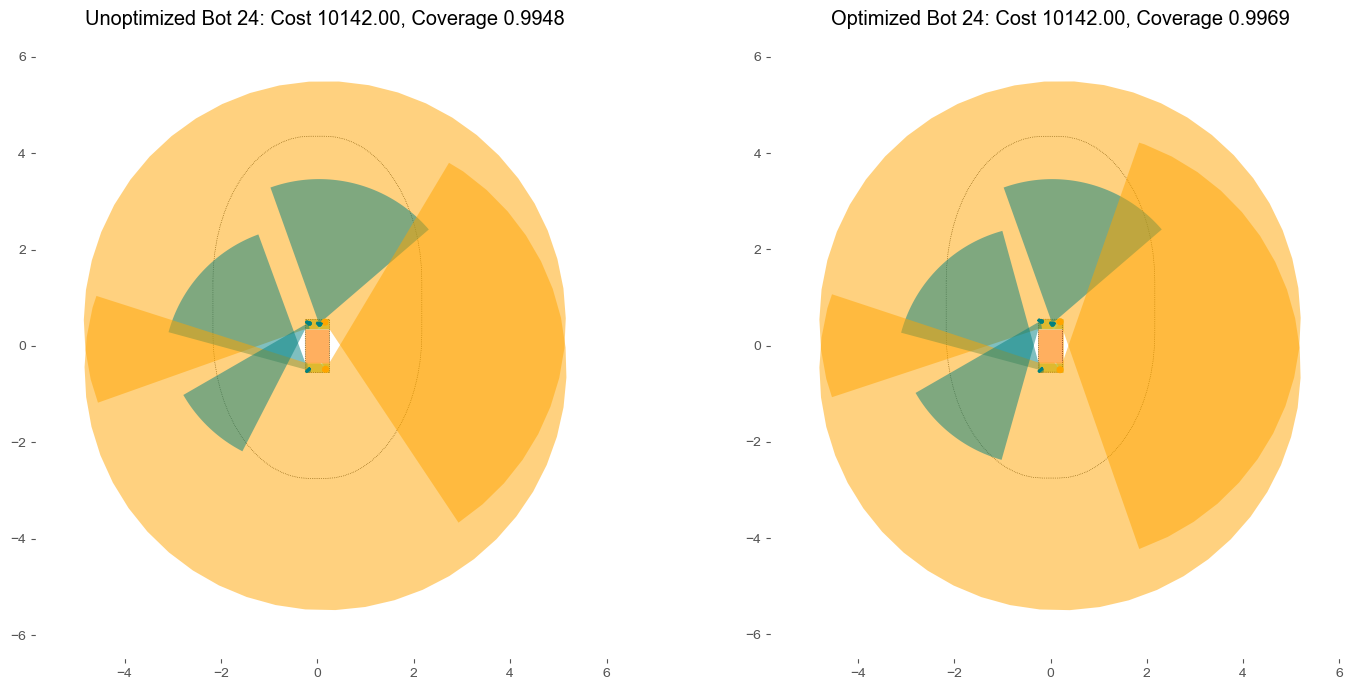

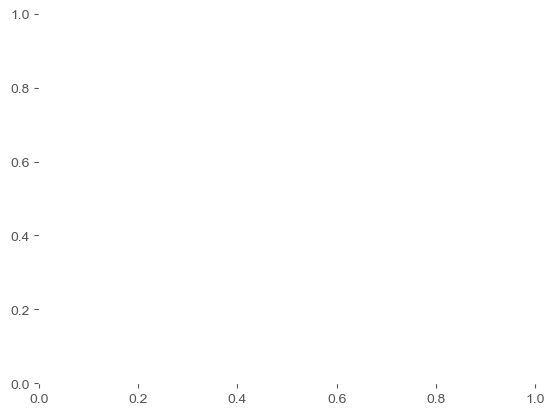

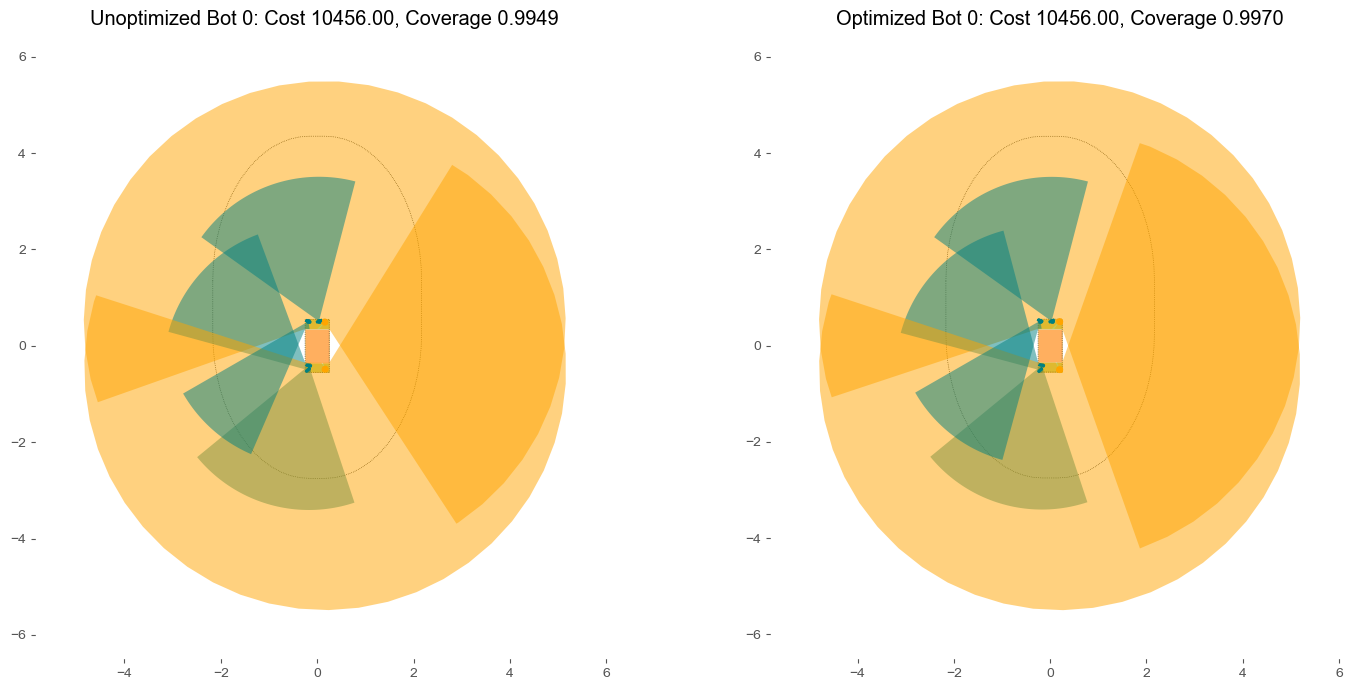

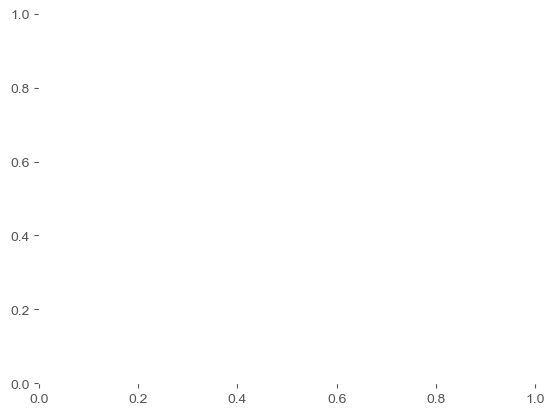

In [11]:
results_optimized = {"X": [], 
                     "F": [],
                     "histories": []}

for idx in tqdm(pareto_idx, leave=True):
    fig, axes = plt.subplots(1, 2, figsize=(15, 7))

    bot = problem.convert_1D_to_bot(res.X[idx])
    bot.plot_bot(show_constraint=True, title=f"Unoptimized Bot {idx}: Cost {res.F[idx, 1]:.2f}, Coverage {1-res.F[idx, 0]:.4f}", ax=axes[0])
    
    bot_optimal = copy.deepcopy(bot)
    if len(bot_optimal.sensors) > 0:
        history = bot_optimal.optimize_sensor_placement(plot=True)
    else:
        history = None
        print("No sensors to optimize! Skipping optimization step.")
    bot_optimal.plot_bot(show_constraint=True, title=f"Optimized Bot {idx}: Cost {bot_optimal.get_pkg_cost():.2f}, Coverage {bot_optimal.get_sensor_coverage():.4f}", ax=axes[1])
    
    fig.tight_layout()
    fig.savefig(f"./_output/{bot_name.lower()}/{timestamp}_botcompare_{idx}.png")
    fig.show()
    
    results_optimized["X"].append(problem.convert_bot_to_1D(bot_optimal, verbose=False, dtype=dict))
    results_optimized["F"].append([bot_optimal.get_sensor_coverage(), bot_optimal.get_pkg_cost()])
    results_optimized["histories"].append(history)

In [12]:
pareto_optimized_df = pd.DataFrame(results_optimized['F'], columns=['Perception Coverage', 'Cost'], index=pareto_idx)
pareto_optimized_df['Perception Coverage'] = (pareto_optimized_df['Perception Coverage']) * 100
pareto_optimized_df['Index'] = pareto_unoptimized_df['Index']
pareto_optimized_df['Name'] = [f"Pkg Concept {i}" for i in pareto_optimized_df.index]
pareto_optimized_df['X'] = results_optimized["X"]
pareto_optimized_df['History'] = results_optimized["histories"]
pareto_optimized_df["Optimized"] = "Optimized"

pareto_optimized_df.to_pickle(f"./_output/{bot_name.lower()}/{timestamp}_df_opt.pkl")
pareto_optimized_df

Perception Coverage     Cost  Index            Name  \
0             99.695841  10456.0      0   Pkg Concept 0   
3             21.643224    314.0      3   Pkg Concept 3   
4             40.122527    499.0      4   Pkg Concept 4   
9             53.598891    813.0      9   Pkg Concept 9   
18            57.751357    998.0     18  Pkg Concept 18   
11            68.199098   1127.0     11  Pkg Concept 11   
14            70.533869   1312.0     14  Pkg Concept 14   
13            77.551728   1441.0     13  Pkg Concept 13   
15            82.815137   1626.0     15  Pkg Concept 15   
19            95.888635   1940.0     19  Pkg Concept 19   
20            98.391957   2254.0     20  Pkg Concept 20   
21            97.562374   2310.0     21  Pkg Concept 21   
8             96.309036   2495.0      8   Pkg Concept 8   
6             86.660459   4914.0      6   Pkg Concept 6   
17            89.750032   5099.0     17  Pkg Concept 17   
16            94.284271   5228.0     16  Pkg Concept 16   
10            97.828231   5413.0     10  Pkg Concept 10   
12            99.179194   6355.0     12  Pkg Concept 12   
5             99.128736   6725.0      5   Pkg Concept 5   
7             99.390555   9200.0      7   Pkg Concept 7   
22            99.582115   9514.0     22  Pkg Concept 22   
23            99.694978   9828.0     23  Pkg Concept 23   
24            99.693562  10142.0     24  Pkg Concept 24   
0             99.695841  10456.0      0   Pkg Concept 0   

                                                    X  \
0   {'s0_type': 3, 's0_x': 0.19743020483028229, 's...   
3   {'s0_type': 1, 's0_x': 0.01946544156075447, 's...   
4   {'s0_type': 2, 's0_x': -0.04572987403994233, '...   
9   {'s0_type': 1, 's0_x': 0.204855816219915, 's0_...   
18  {'s0_type': 2, 's0_x': 0.1338628427681261, 's0...   
11  {'s0_type': 1, 's0_x': 0.20279175982111664, 's...   
14  {'s0_type': 2, 's0_x': -0.16410413366549825, '...   
13  {'s0_type': 2, 's0_x': -0.17214734626081096, '...   
15  {'s0_type': 2, 's0_x': 0.17287067896878927, 's...   
19  {'s0_type': 2, 's0_x': -0.1868575687822256, 's...   
20  {'s0_type': 2, 's0_x': -0.08310236811570615, '...   
21  {'s0_type': 2, 's0_x': -0.032653274342203886, ...   
8   {'s0_type': 2, 's0_x': 0.09832884443892898, 's...   
6   {'s0_type': 1, 's0_x': 0.006235401243712246, '...   
17  {'s0_type': 2, 's0_x': 0.06585531777449738, 's...   
16  {'s0_type': 1, 's0_x': 0.16522040175540909, 's...   
10  {'s0_type': 1, 's0_x': 0.02424856097533379, 's...   
12  {'s0_type': 1, 's0_x': 0.1309673013857493, 's0...   
5   {'s0_type': 2, 's0_x': -0.12944961039489034, '...   
7   {'s0_type': 3, 's0_x': 0.1984750143968954, 's0...   
22  {'s0_type': 3, 's0_x': 0.19825319264800356, 's...   
23  {'s0_type': 3, 's0_x': 0.19842048923269573, 's...   
24  {'s0_type': 3, 's0_x': 0.1982884022234721, 's0...   
0   {'s0_type': 3, 's0_x': 0.19743020483028229, 's...   

                                              History  Optimized  
0   {'fun': [-0.9949362413266852, -0.9949362413266...  Optimized  
3   {'fun': [-0.21642866772776215, -0.216428667727...  Optimized  
4   {'fun': [-0.4011442441735569, -0.4011442441735...  Optimized  
9   {'fun': [-0.52915355940934, -0.52915355940934,...  Optimized  
18  {'fun': [-0.5611009418883101, -0.5611009418883...  Optimized  
11  {'fun': [-0.6402995016059546, -0.6402995016059...  Optimized  
14  {'fun': [-0.6738573096166097, -0.6738573096166...  Optimized  
13  {'fun': [-0.727923703365921, -0.72792370336592...  Optimized  
15  {'fun': [-0.7725236884188391, -0.7725236884188...  Optimized  
19  {'fun': [-0.7947618767293277, -0.7947618767293...  Optimized  
20  {'fun': [-0.8063224644473805, -0.8063224644473...  Optimized  
21  {'fun': [-0.8421575755906447, -0.8421575755906...  Optimized  
8   {'fun': [-0.8599795903903258, -0.8599795903903...  Optimized  
6   {'fun': [-0.861556460946211, -0.86155646094621...  Optimized  
17  {'fun': [-0.8948592914602149, -0.8948592914602...  Optimized  
16  {'fun': [-0.92991210427148

# Introspect with a video

In [ ]:
from IPython.display import HTML

# fig, axes = plt.subplots(1, 2, figsize=(15, 7))
idx = 20

bot = problem.convert_1D_to_bot(res.X[idx])
# bot.plot_bot(show_constraint=True, title=f"Unoptimized Bot {idx}: Cost {res.F[idx, 1]:.2f}, Coverage {1-res.F[idx, 0]:.4f}", ax=axes[0])

bot_optimal = copy.deepcopy(bot)
ani = bot_optimal.optimize_sensor_placement(plot=False, animate=True, anim_interval=100)
display(HTML(ani.to_jshtml()))
ani.save(f"./_artifacts/optimization_animation.mp4", writer='ffmpeg')
# bot_optimal.plot_bot(show_constraint=True, title=f"Optimized Bot {idx}: Cost {bot_optimal.get_pkg_cost():.2f}, Coverage {bot_optimal.get_sensor_coverage():.4f}", ax=axes[1])

# plt.tight_layout()

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approximations.

/Users/robosquiggles/miniforge3/envs/blenv/lib/python3.11/site-packages/scipy/optimize/_differentiable_functions.py:551: UserWarning:

delta_grad == 0.0. Check if the approximated function is linear. If the function is linear better results can be obtained by defining the Hessian as zero instead of using quasi-Newton approxima

In [14]:
# Create the scatter plot
pareto_combined_df = pd.concat([pareto_unoptimized_df, pareto_optimized_df], axis=0)
pareto_combined_df


Perception Coverage     Cost  Index            Name  \
0             99.493624  10456.0      0   Pkg Concept 0   
3             21.642867    314.0      3   Pkg Concept 3   
4             40.114424    499.0      4   Pkg Concept 4   
9             52.915356    813.0      9   Pkg Concept 9   
18            56.110094    998.0     18  Pkg Concept 18   
11            64.029950   1127.0     11  Pkg Concept 11   
14            67.385731   1312.0     14  Pkg Concept 14   
13            72.792370   1441.0     13  Pkg Concept 13   
15            77.252369   1626.0     15  Pkg Concept 15   
19            79.476188   1940.0     19  Pkg Concept 19   
20            80.632246   2254.0     20  Pkg Concept 20   
21            84.215758   2310.0     21  Pkg Concept 21   
8             85.997959   2495.0      8   Pkg Concept 8   
6             86.155646   4914.0      6   Pkg Concept 6   
17            89.485929   5099.0     17  Pkg Concept 17   
16            92.991210   5228.0     16  Pkg Concept 16   
10            97.154946   5413.0     10  Pkg Concept 10   
12            97.206974   6355.0     12  Pkg Concept 12   
5             97.834524   6725.0      5   Pkg Concept 5   
7             99.233260   9200.0      7   Pkg Concept 7   
22            99.270414   9514.0     22  Pkg Concept 22   
23            99.447164   9828.0     23  Pkg Concept 23   
24            99.482225  10142.0     24  Pkg Concept 24   
0             99.493624  10456.0      0   Pkg Concept 0   
0             99.695841  10456.0      0   Pkg Concept 0   
3             21.643224    314.0      3   Pkg Concept 3   
4             40.122527    499.0      4   Pkg Concept 4   
9             53.598891    813.0      9   Pkg Concept 9   
18            57.751357    998.0     18  Pkg Concept 18   
11            68.199098   1127.0     11  Pkg Concept 11   
14            70.533869   1312.0     14  Pkg Concept 14   
13            77.551728   1441.0     13  Pkg Concept 13   
15            82.815137   1626.0     15  Pkg Concept 15   
19            95.888635   1940.0     19  Pkg Concept 19   
20            98.391957   2254.0     20  Pkg Concept 20   
21            97.562374   2310.0     21  Pkg Concept 21   
8             96.309036   2495.0      8   Pkg Concept 8   
6             86.660459   4914.0      6   Pkg Concept 6   
17            89.750032   5099.0     17  Pkg Concept 17   
16            94.284271   5228.0     16  Pkg Concept 16   
10            97.828231   5413.0     10  Pkg Concept 10   
12            99.179194   6355.0     12  Pkg Concept 12   
5             99.128736   6725.0      5   Pkg Concept 5   
7             99.390555   9200.0      7   Pkg Concept 7   
22            99.582115   9514.0     22  Pkg Concept 22   
23            99.694978   9828.0     23  Pkg Concept 23   
24            99.693562  10142.0     24  Pkg Concept 24   
0             99.695841  10456.0      0   Pkg Concept 0   

                                                    X  \
0   {'s0_type': 3, 's1_type': 1, 's2_type': 1, 's3...   
3   {'s0_type': 0, 's1_type': 0, 's2_type': 0, 's3...   
4   {'s0_type': 0, 's1_type': 2, 's2_type': 0, 's3...   
9   {'s0_type': 0, 's1_type': 0, 's2_type': 0, 's3...   
18  {'s0_type': 2, 's1_type': 2, 's2_type': 0, 's3...   
11  {'s0_type': 0, 's1_type': 1, 's2_type': 2, 's3...   
14  {'s0_type': 2, 's1_type': 2, 's2_type': 1, 's3...   
13  {'s0_type': 2, 's1_type': 1, 's2_type': 0, 's3...   
15  {'s0_type': 2, 's1_type': 0, 's2_type': 1, 's3...   
19  {'s0_type': 2, 's1_type': 1, 's2_type': 2, 's3...   
20  {'s0_type': 2, 's1_type': 1, 's2_type': 2, 's3...   
21  {'s0_type': 2, 's1_type': 2, 's2_type': 2, 's3...   
8   {'s0_type': 2, 's1_type': 2, 's2_type': 2, 's3...   
6   {'s0_type': 0, 's1_type': 1, 's2_type': 0, 's3...   
17  {'s0_type': 0, 's1_type': 2, 's2_type': 0, 's3...   
16  {'s0_type': 0, 's1_type': 0, 's2_type': 1, 's3...   
10  {'s0_type': 1, 's1_type': 0, 's2_type': 0, 's3...   
12  {'s0_type': 1, 's1_type': 2, 's2_type': 1, 's3...   
5   {'s0_type': 2, 's1_type':

# Tradespace (Pareto Fronts)

In [15]:
hv_unoptimized = get_hypervolume(pareto_unoptimized_df, [15000, 0], x='Cost', y='Perception Coverage')
hv_combined = get_hypervolume(pareto_combined_df, [15000, 0], x='Cost', y='Perception Coverage')
hv_improvement = hv_combined - hv_unoptimized

print(f"Hypervolume Unoptimized: {hv_unoptimized:.2f}")
print(f"Hypervolume Optimized:   {hv_combined:.2f}")
print(f"Hypervolume Improvement: {hv_improvement:.2f} = +{hv_improvement/hv_unoptimized *100:.2f}%")

fig = plot_tradespace(pareto_combined_df, df_results.shape[0], panzoom=True, width=600, height=450)
fig.show()

Hypervolume Unoptimized: 1336175.29
Hypervolume Optimized:   1389917.94
Hypervolume Improvement: 53742.64 = +4.02%
